# Predict Personality
This notebook is a poc of how we can predict personality trades based on raw text i.e. an application or the history of ones tweets.

In order to acheive this we will use:
* pre-trained word embedding 
* Personality test questionaire
* LSTM to predict personaity trade
* Semantics dictionary
* LSTM to predict possitive or negatie

The idea is to predict the personality trade mach for each sentence and then predict the semantic orientation in order to apply the score as possitive or negative.

We start with the Big5 personalities test: https://ipip.ori.org/newBigFive5broadTable.htm and use data from: http://openpsychometrics.org.

## Download data big5

In [ ]:
import wget
import os

data_folder = './data'
os.makedirs(data_folder, exist_ok=True)

url = 'http://openpsychometrics.org/_rawdata/BIG5.zip'
file = './data/big5.zip'
wget.download(url, file)

## Big5 codebook

In [1]:
# Print codebook
file = './data/big5/codebook.txt'
with open(file) as fp:
    cnt = 0
    lines = list()
    for line in fp:
        print("{}".format(line))
        cnt += 1
        lines.append(line)

This data was collected (c. 2012) through on interactive online personality test. Participants were informed that their responses would be recorded and used for research at the begining of the test and asked to confirm their consent at the end of the test.



The following items were rated on a five point scale where 1=Disagree, 3=Neutral, 5=Agree (0=missed). All were presented on one page in the order E1, N2, A1, C1, O1, E2...... 



E1	I am the life of the party.

E2	I don't talk a lot.

E3	I feel comfortable around people.

E4	I keep in the background.

E5	I start conversations.

E6	I have little to say.

E7	I talk to a lot of different people at parties.

E8	I don't like to draw attention to myself.

E9	I don't mind being the center of attention.

E10	I am quiet around strangers.

N1	I get stressed out easily.

N2	I am relaxed most of the time.

N3	I worry about things.

N4	I seldom feel blue.

N5	I am easily disturbed.

N6	I get upset easily.

N7	I change my mood a lot.

N8	I have

## Extract questionaire sentences

In [2]:
import random
lines = lines[4:54]

cnt = 0
for line in lines:
    split_line = line.split("\t")
    split_line = [s.strip("\n") for s in split_line]
    lines[cnt] = split_line
    cnt += 1

In [3]:
random.shuffle(lines)

In [4]:
lines[0:5]

[['N8', 'I have frequent mood swings.'],
 ['A7', 'I am not really interested in others.'],
 ['E5', 'I start conversations.'],
 ['E10', 'I am quiet around strangers.'],
 ['O7', 'I am quick to understand things.']]

## Create scoring for the questionare
Go To https://ipip.ori.org/newBigFive5broadTable.htm
Based on this, we can se that a statemnet either contributes positively or negatively to a personality trade score.

In [ ]:
score = [1, -1, 1, -1, 1, -1, 1, -1, 1, -1,
        -1, 1, -1, 1, -1, -1, -1, -1, -1, -1,
        -1, 1, -1, 1, -1, 1, -1, 1, 1, 1,
        1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 
        1, -1, 1, -1, 1, -1, 1, 1, 1, 1]

# Embed lines
Download pretrained embedding. Then initialize a gensim word2vec with those weghts in order to fine tune the embedding for the questionaire.

In [ ]:
import wget
#url = 'https://loar.kb.dk/bitstream/handle/1902/329/danish_newspapers_1880To2013.txt?sequence=4&isAllowed=y'
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
file = 'glove.6B.300d.zip'
wget.download(url, file) 

## Initialize word2vec
https://datascience.stackexchange.com/questions/10695/how-to-initialize-a-new-word2vec-model-with-pre-trained-model-weights 

In [5]:
sentences= list()
for sentence in lines:
    sentences.append(sentence[1].split())
sentences[0:5]

[['I', 'have', 'frequent', 'mood', 'swings.'],
 ['I', 'am', 'not', 'really', 'interested', 'in', 'others.'],
 ['I', 'start', 'conversations.'],
 ['I', 'am', 'quiet', 'around', 'strangers.'],
 ['I', 'am', 'quick', 'to', 'understand', 'things.']]

C:\Anaconda\envs\azureML\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Anaconda\envs\azureML\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


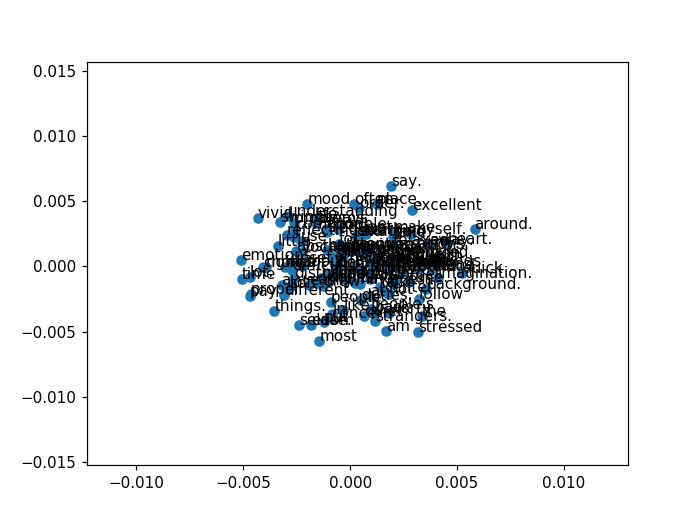

In [6]:
%matplotlib notebook
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

# train model
model_1 = Word2Vec(sentences, size=300, min_count=1)

# fit a 2d PCA model to the vectors
X = model_1[model_1.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model_1.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [8]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
tmp_file = get_tmpfile("test_word2vec.txt")
glove_file = "data\glove.6B.300d\glove.6B.300d.txt"

In [9]:
# Lodd weights
model = KeyedVectors.load_word2vec_format(tmp_file)

In [10]:
#Train on senences with weights initialized from glove
model_2 = Word2Vec(size=300, min_count=1)
model_2.build_vocab(sentences)
total_examples = model_2.corpus_count
model_2.build_vocab([list(model.vocab.keys())], update=True)
model_2.intersect_word2vec_format(tmp_file, binary=False, lockf=1.0)
model_2.train(sentences, total_examples=total_examples, epochs=model_2.iter)

C:\Anaconda\envs\azureML\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys


(1032, 1360)

C:\Anaconda\envs\azureML\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


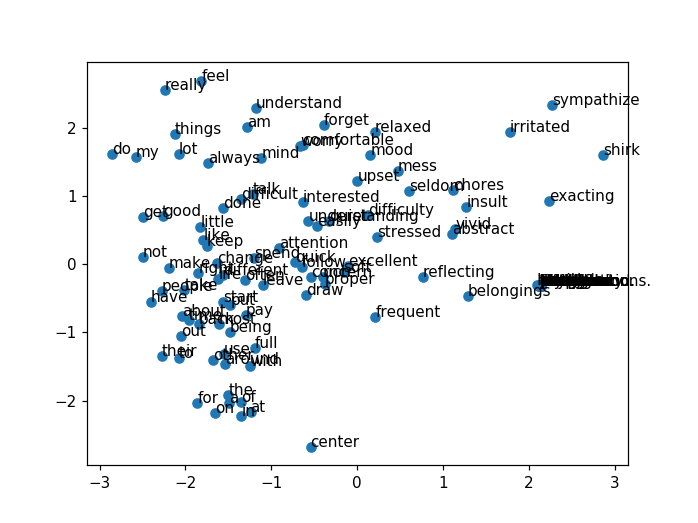

In [11]:
%matplotlib notebook
# fit a 2d PCA model to the vectors
X = model_2[model_1.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model_1.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

# Predict personality trade

In [12]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


In [13]:
# Word2index and back
word = "whatever"  # for any word in model
i = model_2.wv.vocab[word].index
model_2.wv.index2word[i] == word

True

In [14]:
def sentences_to_indices(sentences, gensim_model, max_len):
    m = len(sentences)                 
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                       
        sentence_words = sentences[i]
        j = 0
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = gensim_model.wv.vocab[sentence_words[j]].index
            # Increment j to j + 1
            j = j + 1
            
    ### END CODE HERE ###
    
    return X_indices

In [ ]:
for index in range(len(model_2.wv.vocab)):
                   print(model_2.wv.index2word[index])

I
am
a
have
in
to
of
feel
the
get
things.
my
interested
not
ideas.
don't
people.
easily.
others.
talk
lot.
around
little
people
at
like
attention
out
blue.
mood
often
for
others'
time
make
abstract
imagination.
life
party.
comfortable
keep
background.
start
conversations.
say.
lot
different
parties.
draw
myself.
mind
being
center
attention.
quiet
strangers.
stressed
relaxed
most
time.
worry
about
seldom
easily
disturbed.
upset
change
frequent
swings.
irritated
concern
insult
sympathize
with
feelings.
other
people's
problems.
soft
heart.
really
take
emotions.
ease.
always
prepared.
leave
belongings
around.
pay
details.
mess
chores
done
right
away.
forget
put
things
back
their
proper
place.
order.
shirk
duties.
follow
schedule.
exacting
work.
rich
vocabulary.
difficulty
understanding
vivid
excellent
do
good
quick
understand
use
difficult
words.
spend
reflecting
on
full
,
.
and
"
's
-
that
is
was
said
he
as
it
by
(
)
from
his
''
``
an
be
has
are
but
were
this
who
they
had
i
which
will
:
o

customers
sun
becoming
champions
gulf
gets
virginia
corporate
introduced
academy
particular
survey
easy
mainly
choice
hearing
35
add
reduce
directed
replaced
native
assistant
arts
seconds
crowd
complex
quite
poland
entered
dutch
responsibility
crew
fine
pounds
environmental
subject
organizations
jersey
kosovo
mean
serving
cultural
ten
seemed
bus
yards
cuts
produce
ask
voice
degree
author
watch
lawyers
ice
legislation
collection
presence
shown
listed
critics
rejected
else
offers
influence
ruled
governments
stations
soccer
shooting
arafat
streets
draft
evening
sex
grew
bodies
policies
afghan
editor
rival
nature
strategy
1989
girl
jordan
happy
giant
save
jackson
wing
prosecutors
identified
larger
article
optional
sri
seek
bombing
managed
re
sought
standing
doctors
measure
earned
gmt
rural
fellow
sanctions
bought
smaller
contributed
owner
secret
carrying
prince
treaty
launch
cast
a.m.
highly
civilians
basketball
performed
develop
fair
interior
henry
lawmakers
prepared
malaysia
wrong
tests


performances
nomination
impossible
teaching
liberation
merger
1968
tight
tobacco
carter
attempted
traders
abandoned
missiles
medium
drove
controversy
allen
operate
lowest
sugar
resolve
grounds
affect
64
chamber
aware
directors
hezbollah
orange
1970
oh
ongoing
juan
disney
agreements
responded
roughly
envoy
biography
adviser
ahmed
economist
palm
harry
pool
unusual
elizabeth
worker
ranking
inspired
patient
sat
mining
rating
contemporary
1973
defend
boeing
moderate
deadline
tank
instance
jets
column
visits
reporting
dedicated
recovered
advice
method
joining
arrival
connected
dean
striker
anderson
signal
practices
application
shift
restrictions
testimony
jeff
touch
males
christopher
shareholders
promoted
pushing
myself
covers
organisation
athens
sam
alan
fan
b.
kashmir
papers
failing
device
clark
featuring
recognition
maria
1977
+
preparing
broadcasting
jazz
trillion
birds
fallen
threw
cbs
trend
gross
dry
literature
nobody
apple
tiny
assigned
discussion
colleagues
provinces
prepare
counter


policemen
integration
guidelines
arguments
erupted
rough
wickets
arguing
christians
marathon
victor
contacts
legitimate
factories
attempting
convoy
15th
technique
inspection
situations
symptoms
risen
properly
ferry
folk
foods
derby
1951
achievement
demonstrated
preserve
dropping
cooking
armstrong
semifinals
invitation
prevented
guess
hindu
switch
manufacturer
stuck
l
yang
der
spy
pierre
prisoner
franklin
21st
operational
experiences
necessarily
dynasty
focusing
maine
ourselves
karl
gotten
replacing
feelings
adopt
establishing
todd
et
grace
bombers
wore
proceedings
temporarily
fix
anna
indies
tactics
knocked
kills
provision
uniform
attractive
historian
judgment
lucky
closure
wider
consulting
sudanese
donors
interviewed
credits
prayer
quebec
des
hearings
belt
tribute
straits
produces
asylum
farms
metro
earl
71
plunged
pirates
muhammad
designs
pga
14th
liberty
dublin
wages
equally
operators
visual
shirt
tip
collins
ignored
checks
generate
factions
dubai
forming
lynch
legislators
transmiss

lumpur
simultaneously
identical
priorities
depot
hospitalized
contractors
bolivia
fights
accounted
queens
heavyweight
wishes
ld
rouge
devil
bold
toy
bahrain
hop
headline
emphasized
greenhouse
artificial
underway
tracking
cancelled
lama
lone
justin
disappointment
montgomery
governance
mild
hectares
explaining
fragile
suu
pronounced
courage
93
tasks
monica
oxygen
relation
1910
steadily
preserved
mortar
structural
warriors
cooperative
finances
array
profitable
oslo
imprisoned
soaring
roosevelt
loves
respective
regret
deck
succession
monastery
attackers
decrease
freshman
plaza
oversight
throne
sworn
hamid
challenger
youths
intends
oriented
partisan
unacceptable
shells
125
linda
rwandan
rider
toured
suggestions
8,000
fare
kurds
apec
caps
fitness
retiring
refuses
1926
rifles
scenario
item
tail
chambers
withdrawn
hugo
vermont
borrowing
admiral
suspicious
robust
conversations
scrutiny
storms
basque
impoverished
nurse
investing
romney
coached
mud
organisations
leone
photography
han
unbeaten
mar

supermarket
juvenile
overwhelmingly
intermediate
delighted
navigation
malcolm
medicaid
accountability
searches
privatization
compelling
diameter
sorts
corners
entities
crosses
identifying
deported
resisted
alpha
cyclone
zurich
coleman
spacecraft
grocery
confederate
vi
airborne
volcano
klein
marriages
twist
owed
trash
peer
labeled
dig
dancers
schemes
lately
lou
roddick
richest
upgraded
horizon
benefited
prizes
contender
beverly
varieties
euro1
merchants
ellen
laos
capt.
beds
tying
relegated
proposition
1898
observe
determining
banker
basra
satisfaction
capitals
italians
moo
availability
donation
shoe
appoint
seas
worthy
theatrical
bans
su
ducks
convincing
hawks
dear
prone
unfortunate
telegraph
instructed
peterson
winger
dhaka
disarm
oath
josé
complaining
ab
sticking
fallujah
sah
allocated
metric
innocence
igor
explorer
recipes
candy
adjust
commissions
dissident
islanders
attribution
negotiation
heels
excellence
torch
mir
fruits
fcc
shoulders
quote
moroccan
fitted
consolidated
ransom
sum

bust
unlimited
explicitly
premiums
aston
escorted
organizer
leisure
tornado
consolidate
175
constituencies
mcveigh
knees
rhodes
undisclosed
crater
marlins
108
shui
essays
bride
madeleine
tentative
pumping
tariff
hussain
dynamics
scary
wolves
plots
sparking
crane
champagne
rainbow
chanted
conscience
billed
lanes
suns
strains
30th
mavericks
probability
sensitivity
chin
horrible
arabian
adapt
millionaire
antarctic
boasts
1500
espionage
lamb
concession
fielder
giovanni
us$
suzuki
swiftly
jockey
disagreement
dire
dip
ambition
legends
correctly
chickens
conglomerate
rapper
sore
backward
acoustic
alleging
aboriginal
harlem
scrapped
shores
providence
flip
beth
keyboard
weird
bremen
variant
prominence
carson
grill
salvage
marketed
macau
mahmud
brunei
monroe
tajikistan
whitman
freddie
secretariat
hay
coral
positively
mar
finalists
settings
superstar
4.3
minerals
supplement
sofia
outline
chased
processed
conn.
galleries
osce
polled
shimon
airplanes
appreciated
fundamentalist
bunker
exploit
loomin

spitzer
euro2
eh
allegiance
eligibility
velocity
cedar
heroic
cops
fixture
gujarat
bodyguards
inscription
valve
contraction
hale
reproductive
elevator
burger
enlarged
justification
indie
pistons
calvin
seafood
nadu
vanished
seles
sicily
khamenei
ion
comparisons
boring
iconic
thornton
daylight
18,000
dusty
ce
60th
dragging
prevents
j.p.
funk
1859
med
beit
kuomintang
chu
lindsey
amtrak
doll
jennings
jeep
prostate
preview
7:30
attracts
email
yorkers
lexington
modeling
batters
dare
levine
jammu
transporting
barton
raja
olson
reich
nguyen
>
fraudulent
plunging
frog
oaks
narrowed
resumes
licence
tri
cao
logistical
puzzle
novak
jenny
certainty
rover
townships
slept
forehand
tallest
prostitutes
120,000
sculptor
thigh
stack
rigorous
wires
seventeen
locks
shaft
disperse
massacres
reliever
organisms
fowler
impending
defends
fist
midland
andres
165
elusive
aznar
gibraltar
martina
expressway
horns
trilogy
herb
14,000
widened
charismatic
severed
confusing
abuja
supervisors
continually
hd
goldberg
fa

wrecked
outsider
7.8
hazards
improves
reforming
grabbing
streaming
calculation
undertook
nuremberg
diversified
papandreou
wards
po
snails
divert
lester
kris
ya
amber
confessions
patches
fielded
whatsoever
notch
inflated
jaime
guam
racer
tempo
ghraib
doe
humanities
golfers
biased
extracted
wolfowitz
opel
nautical
stray
bumper
hijacking
proudly
sadc
alias
90,000
illustrate
nutritional
bonnie
sensible
133
textbooks
elaine
evaluating
greet
watergate
corpse
suez
railroads
nightly
acc
erekat
geithner
kramer
controversies
sperm
pike
nursery
incidence
clifford
rumor
mankind
gillespie
tripled
vieira
jeanne
demon
nassau
nikolai
niece
soar
drone
sinclair
redevelopment
allah
raged
mullah
discarded
fritz
mechanic
mauritania
inferior
nominal
7.1
conditional
subsidized
5-3
bullish
orphans
saxony
soaked
migrated
captains
137
sanford
smoked
usd
heaviest
weir
isbn
4,500
200m
honorable
kang
chemotherapy
350,000
stamford
utterly
revise
monumental
reside
deferred
determines
indefinite
unmanned
wakefield
fr

.3
magnate
prostitute
upwards
.4
paddy
y2k
ordnance
termination
lagoon
admire
alicia
distrust
snack
deleted
peugeot
specials
bellsouth
lao
22,000
generale
pp
sloan
berman
contending
ntv
prohibiting
pity
rumored
havel
ike
hongkong
footed
connolly
booster
disgruntled
markedly
flemish
6-5
dalton
decommissioned
stubborn
perspectives
arrows
lusaka
collaborators
pots
congressmen
dakar
backwards
oils
3-pointers
sylvia
westward
favoring
diarrhea
winery
imbalance
cos.
unfamiliar
entirety
ay
reorganized
intern
absentee
alison
hormones
hesitate
mccall
izetbegovic
titan
ganguly
glover
universally
horsepower
jaguars
pauline
excavation
spoiled
lenses
detectors
christophe
bouncing
glamorous
-----
halliburton
hydraulic
ot
gareth
orphanage
equestrian
deadlines
freak
60s
upheaval
disappearing
saturdays
strewn
pee
hug
tara
dye
froze
damien
8.1
angus
penetrate
nate
lra
eastwood
kicker
modernize
handicapped
pins
rationale
landowners
remembering
posture
reese
wraps
neutrality
deity
3-4
same-sex
daiwa
tuning

pettitte
g-7
rigs
conceptual
cloudy
ranchers
guessing
hog
mahr
rb
economical
firepower
chestnut
'n
peacemaking
masri
wiping
galveston
fragment
rugbyu
laptops
cozy
regrettable
spraying
britney
rana
helpless
mesh
mcnamara
taichung
wallet
isa
hare
meg
dickens
hoc
marianne
ballack
rp
primera
stephenson
revolves
xie
greatness
lil
plum
evicted
panamanian
foray
dei
plausible
adherence
dime
duff
sellout
disgust
spokane
39th
dalian
colonists
troublesome
grossed
0000
hymn
slums
grin
gansu
lal
right-handed
lantern
spirituality
axe
libertadores
kosher
garza
hugged
literal
punishments
cy
pristine
nanny
bjorn
ky
swirling
tao
postgraduate
kilos
1819
grieving
edible
monarchs
manipulating
kuerten
signalled
draining
gaston
defection
herrera
slang
symmetry
pleads
murderous
sonoma
fayed
starving
paternal
functionality
shakes
enzymes
dodger
baird
salah
geographically
rotary
ak
sleeves
temperate
737
outburst
dolly
curbs
225-issue
hmos
lt
trenton
peck
conversely
af
defective
176
capsized
fernandes
az
saul
pe

monastic
semiconductors
resurrected
lea
shear
lena
punctuated
housewives
jacobson
ore.
nailed
breathtaking
olives
herve
mirrored
mocked
1860s
paycheck
cavity
phyllis
lamy
53rd
deacon
footprint
injecting
salvaged
faxed
pleasures
frontman
swamped
homegrown
dewey
antics
blindness
eighteenth
hilarious
paranoid
mcpherson
goodyear
arlen
tobias
buoyant
looters
invasions
limbaugh
vapor
mattered
giambi
hostel
denials
tides
hesitation
downey
reservists
pathways
culled
ornamental
universidad
subaru
antony
fuse
futuristic
scourge
remixes
loops
warhol
crossfire
rongji
specialize
hasty
relayed
condit
levelled
ina
prefix
charting
raza
eyeing
maddon
unloaded
dolan
brahimi
admirers
seychelles
subscribe
indecent
204
penang
complicating
vowels
mundo
256
infancy
nativity
deprivation
sac
akram
unaccounted
entitlement
nagoya
deans
carrot
yiddish
ras
cricketers
avail
bash
groomed
301
wharton
senatorial
props
jolted
rosy
trimming
mod
mustang
100-meter
scholastic
anonymously
condo
adept
ions
flux
ehr
roam
goss

sai
72nd
regeneration
rocco
revolutionaries
puppets
layered
corsica
simeon
yell
iceberg
humour
confidently
vaccinated
allergic
boxed
brazen
miraculous
kun
prognosis
shwe
sheppard
12:30
ser
fukuoka
neh
number-one
emblazoned
grounder
proclaim
ja
squirrel
bain
steinmeier
qtr
gettysburg
democratization
decorating
relish
crooked
batons
portman
1997-98
kara
airbase
informants
census-designated
bloodied
intrusive
html
pre-season
imran
clearwater
passers
brando
aspiration
thematic
evangelist
whistles
vazquez
directives
1.45
waned
mansions
recounting
voodoo
hobbled
fragrance
mou
rhetorical
cinematographer
fostered
gilani
hampering
thrashing
submissions
drizzle
grit
placid
harbors
souter
reasoned
flea
0.06
ascended
californian
1950-53
gamblers
bulger
basal
protagonists
masterminded
pardons
scorched
yilmaz
pero
startled
vending
anz
parameter
puget
regatta
orbits
functioned
barca
amalgamated
stacey
broadening
thrashed
226
croix
phosphate
diminutive
lasers
precedence
sabre
countering
cq
capsules
pe

77th
zapatista
nortel
apologised
1998-99
joyner
neighbourhoods
mixer
choppy
poked
poznań
condominiums
1.12
sauvignon
ezra
directv
tarantino
tabled
flashbacks
skyrocketing
calmed
nobleman
cantonese
sleeps
dialog
salads
g-20
indexed
snub
cones
basins
seine
requisite
intercollegiate
horrendous
elaborated
246
aprilia
funcinpec
uniformly
maputo
gatt
geffen
triples
3,300
mcdougal
eras
edna
channeled
nazareth
chained
gadget
heartbreaking
benevolent
gothenburg
arabiya
tout
reacts
boosters
camels
harshest
0.19
zell
uno
bachelet
patterned
unto
bismarck
hotter
pharmacist
sadler
nirvana
disable
ethiopians
milder
serviced
fishes
spurned
thorne
bowers
reiterate
exuberant
precondition
soriano
leftover
parmalat
loot
kpmg
stately
grapple
erika
scrape
daniele
clampdown
proficient
vettel
literate
garzon
dahn
conformity
ismael
leyland
zawahri
gia
swanson
220,000
ragged
pérez
maroon
unborn
panasonic
vp
gasp
donned
777
michelangelo
kabbah
vidal
mohawk
pollack
underline
folder
kimi
coefficient
somerville
sea

anderlecht
wehrmacht
guideline
deportations
orthopedic
megabytes
peer-reviewed
268
gonzaga
unequivocal
chivas
sochaux
reintroduced
upholds
viewpoints
malignant
dazed
gravy
radars
fernández
korda
replenish
clique
clegg
palmeiro
caches
vertices
toad
barricaded
hush
canons
disallowed
heighten
interspersed
tarzan
oly
maru
geometridae
deceived
sus
modelled
inflatable
impressionist
oldies
olympique
thanh
hagel
orrin
gannon
underdogs
baring
lasorda
lucknow
warranty
modernizing
267
roughing
granger
moviegoers
precedents
pall
geothermal
torrance
hourlong
paradorn
intellectually
chromosomes
positives
mata
clung
czechoslovak
felons
kaunda
0.55
slush
libre
financiers
tsonga
branched
televisa
gorillas
80-year
est.
neuroscience
stances
mendez
15.8
brothel
foote
meen
watchful
0.29
silesia
tutoring
279
nexus
westfield
misty
littleton
pulses
ney
audacious
seductive
outweighed
carly
1.01
euronext
brittle
leiter
bassett
deutsch
unison
polluters
dani
triad
abnormalities
unchallenged
pendulum
kimberley
pet

behemoth
seizes
uplifting
48-hour
arrays
pba
analytics
krause
eagerness
1.56
grammatical
scraping
osborn
bulletins
colo
mchale
lorient
matrices
pare
bea
solheim
a.g.
coolidge
azul
nutrient
starch
venturing
catalytic
suitor
0.41
hindustan
1640
chopping
lymphoma
falklands
liquidate
3,800
goodies
dew
dependable
mcnally
lyme
discounting
peacekeeper
dina
polygamy
chafee
fbl
jacinto
redgrave
düsseldorf
semen
extinguish
congratulatory
salih
colgate
schreiber
bleach
liquidated
harmonica
non-governmental
narasimha
meta
showings
informative
thaci
1.11
fellowships
glimmer
rajoelina
renovating
mysore
mccollum
yardage
59-year
justifying
citywide
airtran
markovic
corral
polaroid
indochina
tempers
drawback
puree
formula_8
redeemed
1.47
shum
learners
darcy
trieste
cheats
bas
nedved
eyesight
leans
velez
objectionable
1.21
hendrik
780
swooped
hertz
manu
cellist
fundraisers
clube
skied
unforeseen
flimsy
civility
dads
heeded
casillas
clamoring
classy
ballooned
zaki
redefine
stockpiling
taunted
schiff
rajo

badger
ballgame
drubbing
polymers
ebadi
5/16
sankoh
amphibians
strom
moea
sketched
ballets
hilbert
epsom
combed
1993-94
jehovah
gilliam
anthropologists
kali
topological
10-1
persie
inconsistency
pressurized
fjord
symmetrical
sliver
shawnee
shaggy
wrexham
kbr
sahd
biochemical
discharges
aldrich
regev
skakel
koenig
radiant
aquitaine
breezes
bafta
inversion
exhilarating
infractions
covent
yahng
jenrette
jingle
acknowledgement
angelides
officiated
1.53
77-year
revolved
insomnia
coldest
instituto
hz
mla
nnnn
knin
portrayals
gleason
barnier
pancakes
1330
khai
animator
sunflower
hur
fiorina
firewall
loc
horan
contrived
nel
grafton
chimpanzees
sakura
delegated
divest
re-established
magma
transistor
nicholls
grumbling
back-to-back
hm
krupp
messengers
idyllic
shippers
oahu
efficiencies
dominicans
duisburg
covington
custodian
alvarado
2008-2009
deflection
1771
metaphors
512
21.6
abramovich
lacklustre
southend
ellie
deere
humvees
beh
resale
bei
jeong
cocky
arbil
wahn
chipmaker
futility
perpetuate


7.25
breather
wager
sud
chronicling
ghostly
physique
directories
mears
disbursed
checkout
tiered
24.6
averse
elizabethan
hovers
leery
smartly
kevorkian
emissary
koji
edifice
disapprove
sportsmanship
avocado
orator
berwick
biodiesel
laver
facilitation
sailboat
airforce
susanne
outputs
neve
rutland
frontieres
celibacy
dhl
hurriedly
pinyin
cotta
stroud
gingerly
privatizing
dockyard
depositions
espy
postmodern
kewell
bernabeu
douste
slapstick
methodical
flavour
lynching
dereliction
bravado
legg
blowers
emptying
drexler
1757
itc
normalizing
eastbourne
authorisation
purists
enfield
gol
seward
leila
syphilis
coexist
sergeants
1.51
madeline
duhl
gori
bien
icj
dir
hca
zeroual
332
whim
walnuts
implicating
moderating
bloomingdale
absurdity
nebula
gunboat
caro
conceivably
outlawing
outclassed
tietmeyer
topolanek
rhapsody
reinvigorate
1642
butterfield
kiosk
llanelli
unambiguous
corbin
piped
devin
unfurled
u.s.-british
unreal
terminates
mau
brits
horatio
belatedly
taba
melon
caribou
barter
menzies
l

leghari
vestiges
adil
classically
apprehensive
meandering
rais
moises
spreadsheet
petrie
violins
2.13
bohn
andalusia
hellenistic
mennonite
kafka
executes
367
interpersonal
parnevik
looping
niels
adr
pharmacology
levers
precedes
lamenting
parched
merciless
21.2
metall
strenuously
brant
malayan
powering
uml
pancake
unp
leem
prophetic
glancing
lozada
dostam
17th-century
ayub
1min
bakri
truckloads
screenwriters
grays
clippings
fainted
cognition
agnew
flirted
1.93
u.s.-mexico
detects
shakedown
banharn
mandir
chronicler
shouldered
soes
lautenberg
coolest
vehement
kamen
cepd
rizzo
hillman
shiraz
wearer
soundscan
maharaj
aspires
attachments
multiplying
unreported
transcends
aquinas
epitaph
inflorescence
patched
suny
ilham
surrenders
buttocks
5-11
dems
greig
biopic
piloting
budd
swarming
jaded
zeevi
chakvetadze
annul
unbelievably
tierra
transistors
furs
raju
unmovic
middlemen
zenawi
speight
admonished
attractiveness
bubbly
constants
cobain
salter
spadea
bouncer
parlors
electronica
reis
1990-91


susceptibility
pecans
tzu
1741
zubaydah
stockbrokers
zou
perk
ratliff
sik
gastric
amass
ngc
contemplation
recitation
unicorn
département
darnell
stunted
conserving
afonso
snp
shackles
yells
faxon
menard
afoot
benzema
grenadines
rensselaer
gules
rampaging
graying
roiling
mannesmann
ensues
σ
heidfeld
cohorts
rts
css
330,000
idiom
fireplaces
undeniably
gendarmerie
malawian
reconciling
tori
outcast
ui
conti
palacios
corals
penance
metrics
playmate
bogotá
himachal
rimmed
inching
mitsuzuka
handicrafts
resourceful
ares
lithuanians
juris
zoned
cocoon
taxon
95,000
communicates
tasman
ast
reconstructing
propagate
pir
townsville
insulate
gamba
orangemen
detachments
cuthbert
azzam
loggers
under-23
esperanto
thong
biljana
campsite
minaya
l'aquila
pienaar
costumed
carnivorous
dvorak
exclusivity
blockers
hedgehog
smithkline
linkages
moray
niles
exec
partitioned
kingdome
meted
hallucinations
antonov
fergus
ganassi
localization
sheath
feathered
374
kitchener
underwriter
m-16
madrazo
volleyed
confounded

kermit
aeg
mugs
deceptively
junkies
messinger
hornish
avionics
harrier
barth
mea
sauer
eateries
prioritize
footbridge
minardi
tenfold
sighs
murmansk
liv
2.31
execs
foxboro
socio-economic
warms
instilled
eminence
learner
blackwood
6-month
methanol
hiller
fretting
yeomanry
riaz
luxuries
inspirations
iridium
brodsky
galina
maktoum
pedophilia
aes
tyrrell
florio
edmunds
reforma
steinbeck
reggio
servitude
tamar
sucks
back-up
italianate
gundam
rapture
3a
jaromir
achille
helplessly
tranmere
curley
ittihad
reps
mentored
swinton
peered
lumped
logjam
silla
imac
oneworld
cuevas
blythe
fresher
overzealous
sinden
vermeil
dedicating
hatches
rebbe
ganesh
nong
sayles
palmerston
sala
fairmont
leif
illegals
euphemism
392
1675
igman
sportscaster
backpackers
3.45
skirted
hangout
b1
millie
kilgore
bede
2.46
decoding
findlay
llewellyn
théâtre
mol
demeaning
smolensk
workday
mano
0-5
som
inflexible
vero
hellman
byes
snead
askari
blanked
wis
goings
scalar
relinquishing
502
ponders
tripura
ratcheted
copious
dolb

winehouse
alderson
honorific
92nd
jesús
bobbing
unorganized
1728
unbeknownst
eldorado
murdock
overstepped
crescendo
corinne
dwyane
demetrius
whittier
randomized
betterment
wariness
1612
bridged
musings
kramnik
397
marston
quadrennial
ousmane
cuche
uneasiness
heeding
unyielding
10-game
pedophiles
schuylkill
corny
blinds
workweek
stoudamire
1618
unending
multilingual
stroked
banerjee
maw
halsey
opts
15-9
drnovsek
taoist
parte
marginalization
cosworth
awakens
neeson
philatelic
49.5
caplan
horseman
assassinating
humanistic
regalia
1560
piggy
nag
heatley
apologetic
a330
fáil
30.2
1636
1450
1738
ks
sybase
edicts
profusely
deregulate
1699
weisman
shuai
pamuk
457
pyotr
brutus
neonatal
quarrels
nefarious
alluvial
poached
abram
genomic
earp
sub-saharan
typeface
ensue
totality
checker
kickboxing
hurtado
alludes
tuba
truffle
concierge
catalans
natale
schoolyard
phelan
mccord
chn
accede
confining
decomposing
burnout
13-0
0830
numeric
bookshop
mahabharata
ridings
bagels
imaginations
laundered
recalc

akiko
hardwick
governorships
goebbels
aqueous
eke
rusted
rayner
one-half
manassas
x1
ammo
destabilization
hypo
stockwell
enormity
cavite
loews
gholam
diwaniyah
captioned
1639
leeks
tiberius
448
okrug
marinated
mof
nani
euro19
postulated
heterogeneous
envisage
distal
workstation
hock
groundswell
3.13
elin
jalili
srp
touchline
raina
venting
midwives
mississauga
würzburg
portability
rx
attorney-general
5,700
sorcery
muscled
plums
delisted
deflationary
tigres
sahb
strove
bureaucracies
thrusts
hazara
orinoco
meteoric
holger
air-breathing
3.85
oxen
bighorn
sinan
tacos
innovate
commend
queuing
passageway
salonika
5,800
deflecting
discerning
funerary
augustinian
ducal
outmoded
surreptitiously
antebellum
pascoe
dmc
fluttering
firecracker
caminiti
colorectal
rath
despise
pillaging
cleans
shahak
off-road
expendable
ideologue
connective
cruelly
testimonials
rediscover
reorganised
heikki
douse
halibut
inertial
intricately
lutherans
thinned
isidro
refurbishing
baros
henkel
jumpsuit
branca
cruiserwei

jakub
steh
allegro
environmentalism
supergroup
caravaggio
parachuted
kidnaps
coahuila
hauls
adversarial
descartes
delirium
richelieu
hussars
flatley
riled
capella
outboard
33.4
alfalfa
edson
premio
sputtered
colluding
vg
toth
grammer
unicameral
synth
519
norad
odis
trudged
omi
appetizers
bingaman
sofas
ealing
pales
extratropical
humala
shockwaves
marrero
bzw
year-end
hangers
marne
muppets
amram
outbuildings
westbury
bonny
cliburn
afptv
khalq
proudest
speedboats
bbs
grating
provincetown
sugary
spanking
dodson
lecrone
4.45
etheridge
balsamic
jtwc
unfavourable
1521
narco
10-11
arkin
otros
natchez
lpg
incessantly
rarities
bottoming
snaked
kombat
6,700
shebaa
jaffray
bushnell
commoners
deleting
payloads
busily
boldon
ecoregion
african-americans
zara
accademia
mykola
cabal
biya
whorls
bromide
40.5
inferiority
lotion
pb
ulan
granddaughters
zlotys
lanqing
horse-drawn
vere
baguio
613
32.3
snowstorms
divulged
levada
thain
rybkin
dogmatic
34.4
brainstorming
clasped
frontlines
farcical
bek
bpa
bun

amuse
u-19
newsmen
pranab
benedetti
thah
tunneling
888
cymru
blackbird
medway
fino
sniffed
bofa
famines
sultans
by-elections
coleophora
genoese
tübingen
nwfp
masahiko
airtouch
hoarse
pda
552
harland
conquerors
unfairness
oedipus
9-8
a400m
uptight
flowered
4.65
subtracting
soma
blunted
livonia
thoroughbreds
expander
emiliano
o.c.
glassman
tarja
bettini
stovall
hel
nucleotide
chuckling
trish
gainey
shourd
mistresses
christo
440,000
inducements
napkin
mti
awadallah
sabliere
hogarth
grime
dor
magenta
koufax
raving
jigme
taluka
15-3
n.w.
numbness
comically
farmstead
haircuts
graziano
accuweather
zabaleta
thyssenkrupp
536
boron
electrolux
arno
reassembled
7:45
hyperactive
riser
ople
layering
gabba
632
mbna
eccles
tindall
keener
hobbyists
omnicom
shoestring
professes
haakon
cursory
kampung
figgins
accumulates
panionios
tailgate
narendra
meditative
downes
slava
agarkar
ezzedine
burrowing
kata
unwell
noblemen
rourke
overlapped
porridge
weu
conch
doria
801
reissues
dogfight
dieting
billington
h5

infidel
manar
gaya
ub
rowell
cafeterias
leakey
wojciech
petre
moc
mowlam
venecia
rivaling
liffe
buckling
37.3
catlin
oxycontin
skippers
hollandsworth
tint
polish-lithuanian
c.s.
plied
gesellschaft
unmasked
statins
naftogaz
hobbes
sold-out
encirclement
underpass
pelting
frankfort
f-14
mo04
modernised
1591
yardley
katja
rollicking
weng
ligety
310-996-0089
meditations
dissipating
recapturing
thornhill
3s
voice-over
ndjamena
yawn
foale
encyclopaedia
bl
permutation
handicaps
shepherded
stam
tannenbaum
50-percent
chunghwa
hushovd
confucianism
profusion
laud
shree
ensnared
hasselbaink
mush
feasting
poulsen
baptismal
hams
perennially
punks
swazi
cavaco
interplanetary
copts
reflexive
sortie
hacks
madani
lefties
anya
emirati
wide-ranging
polarity
fucking
amador
leek
ef
lemur
disobeying
otunbayeva
alexi
thumped
boyer-ahmad
dey
phonological
misadventures
ost
multi-instrumentalist
trickier
kama
screwdriver
exempts
isr
well-developed
llamas
georgie
93rd
behind-the-scenes
wknd
memorialized
formulae
c

breaths
deserting
backtrack
ame
firework
craved
hata
o'dowd
csn
osceola
rightists
engrossing
dawei
bubka
craybas
109th
unneeded
ooh
twang
wellman
tawdry
magen
yahia
14-3
nmr
marginalised
counter-attack
ticketed
bogle
cienfuegos
ogaden
hulled
salve
eniwetok
.17
corker
gerg
klusener
nahuatl
chelyabinsk
anise
dissuaded
toomer
drosophila
abounded
rear-admiral
tua
hitmen
blinked
13-day
rancorous
reade
138,000
aram
13th-century
dirac
bosom
allele
aliyah
97th
chafed
sleds
spits
shuns
3.56
unfpa
gudjohnsen
qiyue
unionism
rathbone
nicolaus
isomorphism
μm
woodhouse
tammany
bowdoin
trudy
lambeau
depeche
aiko
pretorius
tienen
bundeswehr
webcam
sula
sliders
emmerich
simona
underperform
ooo
re-establish
meteors
651
bluish
donn
hemings
jardin
lovejoy
nsb
trnc
carabidae
casio
haz
refocused
governess
florets
prerequisites
amazonas
10000
1537
contras
22-23
muay
carre
gosford
hoogenband
vidic
montas
boetsch
formula_26
kyoko
chakra
jean-claude
olney
colson
wiles
bacharach
1420
shirtless
paneling
rearview


kenteris
nzse-40
abt
snickers
spitfires
annandale
dfl
troicki
mindoro
zsa
siemerink
watertight
permanence
retinue
bioinformatics
41.2
spann
ferociously
shears
portuguesa
heide
byway
lipids
2021
paducah
cubist
co-edited
valais
carelessly
transparently
macneil
diab
ddr
raimi
638
mashal
8:20
glick
bliley
eto
haradinaj
dutiful
rishi
jamaa
intonation
18.0
forklift
klebold
huddling
vann
shahin
icelanders
longwood
erving
vidya
butting
hanja
lusty
lapid
segui
raduyev
14-10
fabricate
valeria
885
matra
marshmallow
quebecers
48.8
dimpled
arish
zainal
w.va.
25-20
undertones
rusk
non-traditional
circuses
ascends
charing
3.72
homespun
yamuna
behemoths
outspent
coupet
vay
riddles
perverted
carnivores
udine
diuretic
carmelite
thurgood
gilda
sook
guiyang
pogroms
necrosis
operandi
805
buttressed
prudhomme
71,000
nisbet
escapades
disobeyed
kuiper
1524
maggiore
loring
adrenal
shipboard
orlov
twirling
laurier
geopolitics
titov
longstreet
802
lyttelton
108th
rigas
delanoe
sueddeutsche
jordaan
tsutomu
629
hl

bugatti
guile
lentz
toma
putrajaya
500cc
tszyu
dri
pondicherry
headings
llama
optimizing
ridiculing
metroplex
strayhorn
subsiding
gloriously
pala
7,300
tavarez
cozumel
lasith
bunds
reprocessed
1490
lysine
paseo
shirakawa
sacrosanct
nutritionists
curatorial
tolbert
bss
quadriplegic
recombinant
raad
saint-germain
last-minute
interurban
652
reportage
danner
straws
godsend
viana
connerly
octogenarian
50.7
reproduces
deakin
caloric
elinor
ellsbury
48.2
seaver
rawlins
carnation
kenosha
multnomah
hyder
parthian
droll
piecing
reliving
simeone
greyhawk
mcas
kaji
basked
dibaba
esmat
mesopotamian
shuttleworth
tubers
astrologers
three-member
23.0
ghat
cmos
erykah
folha
9.75
hutch
riverview
merz
slotting
karolyi
canard
653
predisposed
angeli
manaus
timbuktu
coincidences
maciej
stringing
oftentimes
simulcasting
mowers
doss
saarinen
1215
serbians
coombs
taxicab
walford
hitchhiking
waring
celera
tulkarm
chowk
wickmayer
rudra
distrusted
dede
first-hand
sympathizer
caw
l2
trax
ntu
subfamilies
s2
mumps
4

deformity
10-round
chaise
724
striptease
ravioli
microscopes
lookouts
cask
ngoc
yoshihiro
basingstoke
6.40
turncoat
squirm
keye
notimex
constipation
destinies
postures
51.6
agitators
hermosillo
sorbet
cromer
corte
i-75
dolomite
wirelessly
semarang
pushy
caterers
takeuchi
bou
swathed
nishimura
bilic
hoeness
peri
girdle
mohmand
wec
tingling
adelson
sokolov
14.99
brooms
chaman
triangulation
buri
capuano
ramachandran
tithe
finsbury
gwyn
categorised
48.1
elfman
koss
hotshot
schuler
haut
cuper
500-meter
gregory-aland
aureus
diameters
four-wheel
thoma
earnestness
interdict
uddin
riotous
sturges
52.6
corkscrew
actuaries
mulan
sledding
hayatou
usha
8/6
devault
philologist
6,100
chroniclers
cilicia
g5
forerunners
fractal
772
barbadian
gyroscopes
ludmila
gracillariidae
individualist
aloe
kongo
cota
gatland
unearthing
handlebars
20:00
josefa
unblemished
earley
jibe
mils
faht
wcup
yahf
fides
669
baqir
desh
xxxxx
objectors
kees
elvin
pixies
lote
sinkhole
gilder
verney
piney
refinanced
donatella
6-fo

enlivened
cowering
aweys
wafted
marinate
stretchered
balloonists
oxymoron
daffodils
intravenously
ldcs
leggings
crm
velcro
ausmus
unkempt
emeril
cyrix
buccaneer
o'donovan
londoner
cif
grandi
hostettler
13-7
idema
determinants
dandelion
ploughing
,3
742
congratulation
curative
663
gisele
doak
elks
pek
osr
nibbling
duva
aswat
adherent
whaler
hillier
obscures
mot
wabc
bailiffs
archivists
iguanas
tabitha
alcalde
addled
cuneo
lundqvist
mccray
honked
sampoerna
emulsion
aranda
scandinavians
swab
restlessness
psychotropic
conquistadors
n.a.
botulism
stags
goryeo
bayview
hailey
ntc
studiously
redlands
jessen
108,000
sutras
relativism
herbivores
centralization
bernese
grafting
misdirected
homeopathic
benayoun
o'kelly
jeroen
subterfuge
redfield
bmt
rith
rollo
bowser
4.23
hodler
arai
grandly
lbc
diệm
plunked
520,000
epithelium
tryst
kum
impure
judgeship
isc
democratisation
crimped
booz
vfw
6.05
lampre
mucous
1780s
4.66
merrily
permissions
franchisee
jemima
rizzuto
thigpen
10.25
barbieri
4.88
lambe

paderborn
904
donut
agbayani
emeka
bankrolling
df
abdus
bie
cga
welland
824
56.3
4.81
nus
hew
seigneur
questioners
pascale
sekolah
picnicking
.84
sundowns
rattlers
provenzano
guhn
poetical
iterative
shrimps
763
re-issue
antitank
fingering
koren
brayton
folklorist
paulette
mellowed
missive
quivering
4.41
moraes
acceptances
popovic
schoeneweis
nodules
pardoning
kbit/s
pata
pauper
fancies
varley
peh
hylton
hamar
wiesner
jeannine
arauca
cholmondeley
buhn
unattached
cation
sepsis
cervix
persecute
mila
medica
homesteads
pulsed
dwi
40-day
four-door
tiredness
4.52
macinnis
goren
hinojosa
snohomish
paiva
ahh
jauzion
zimonjic
pruh
gyroscope
determinism
rinehart
haneda
h.l.
hetman
traumatised
3:10
goldfinger
equitably
prato
fathering
ramada
5.14
zulia
frontcourt
14-6
prosthesis
shales
incubators
garnished
bluffing
northeastward
grayish
honeymooners
spurlock
disappoints
17-19
german-born
cession
8,100
llywelyn
1368
mmx
862
leventhal
widmer
brogan
paroles
etchegaray
bresnan
kosdaq
mid-september
tib

zhelev
islandwide
krantz
91.5
chaput
fevered
ool
zuniga
mottola
daughtry
claymore
lofgren
kellen
jakaya
leaching
dixit
seleucid
822
gto
masaki
atacama
aqueducts
imperium
liguria
hernán
brava
futurama
subtler
mete
ahmadiyya
palencia
kapp
airpower
fim
contravened
elizabethtown
sportsperson
apia
groth
miz
frazzled
u.s.-north
muricidae
prophesied
carpathians
animus
cenotaph
incinerators
spirituals
theroux
enacts
beeching
skynyrd
cerezo
yore
sandbar
proffered
astroturf
crabbe
gono
whittingham
takayuki
slackening
knockoff
8:40
laperriere
cobi
anatomically
4s
anglicanism
gow
intimated
plugin
westcott
kalinga
horsley
modality
oceanographer
livonian
hardwicke
stiffest
ravana
daf
edgewood
sm-liiga
2007-2013
guede
euro28
non-government
cormorant
niš
1390
characterisation
bricklayer
l1
volcanism
oneness
angara
vytautas
2008/2009
wegman
second-half
rabinowitz
barristers
co-hosts
qe2
pym
ouellet
sturrock
patrolmen
itemized
silicate
aeon
undeserved
hewlett-packard
preoccupations
chanson
bronte
biopsi

gadgetry
wearers
lefkowitz
mathur
4.73
rtp
hanish
stocker
ober
bicknell
insanely
metzelder
pahr
condescension
tadashi
repentant
siddons
untamed
tsingtao
injectable
alamein
starlets
sukhumi
restarts
mang
pierzynski
frontenac
befits
moldings
aunque
scrums
mauger
cudicini
redefinition
radom
leiber
sceptics
gangly
1:50
brackett
boxcar
soule
pac-man
bundesrat
grenadiers
snelling
emerton
31-yard
shukrijumah
sekiwake
wadih
felos
berta
incisions
machar
ilyas
bradlee
quint
crunched
franke
growls
expansionary
923
parodying
newby
vezina
0-for-4
sentral
maplewood
overbought
20-billion
yaht
lowercase
amulets
high-risk
foregoing
anthracite
54.6
palladian
egotistical
movin
5.18
swingers
tracheotomy
sluiter
mistura
kaaba
toei
hannu
abscess
compensations
degrades
104,000
detox
913
katha
simian
squier
kardashian
d'orsay
brophy
cci
moustafa
klassen
olonga
u.s.-south
waalwijk
ernests
shigeki
kresimir
spooks
mutinied
off-campus
851
bhushan
italo
popemobile
,4
kangxi
edoardo
wold
showa
otello
frowick
2-colu

cocos
fairtrade
680,000
ameer
hamsters
yount
94.7
moxie
lantz
downsides
drafters
spiteful
helipad
gaucho
erbil
zhanjiang
kahm
cdos
recursion
akhenaten
theropod
tyrell
bamford
snowballs
honoré
kryptonite
929
lass
1:25
gromit
eakin
zacharias
bookie
hiroko
6.38
aaj
lonergan
concoctions
budennovsk
unfeasible
squats
obtainable
damped
idw
adagio
basilio
industrias
ncb
tans
patuxent
clowning
seaworthy
hysterically
irgun
yur
altona
bookcase
pratibha
yvan
maracana
netizen
fraiche
badat
abdollah
rahng
(512)
bailly
lucan
clemenceau
839
feelers
bludgeoning
treetops
spoonbills
managements
forfar
rubik
jac
persimmon
havelock
banjul
sian
hyping
latam
assails
soderberg
derian
hydrate
oligocene
chaff
fastidious
brooker
knuckleball
isoforms
fistfight
flatts
mits
8.20
aspin
shizuka
floorboards
brats
itzhak
aqap
muntari
concretely
874
dumpling
chalets
conjugal
linehan
erlich
toppers
flatt
sealer
zetian
ipanema
daredevils
geoghegan
lansky
noland
markos
revote
barbora
fashanu
luan
pennine
bronchial
followin

erdemovic
holyrood
chartering
academical
antiquaries
constraining
pushover
srinivas
flickered
mishmash
cutlass
jala
inoculate
rapacious
chiswick
pleadings
montmorency
frommer
jawbone
headdresses
poacher
snowmobiling
92.1
spader
rehearing
mcgarry
norgay
bickered
akinori
woori
flecked
esperon
8.0-magnitude
dharmsala
gimenez
hieroglyphs
burstyn
searchlights
non-negative
extrapolated
cloisters
magnificence
publica
newswire
metrorail
-9
spahn
naguib
tagesspiegel
pleats
disrespected
camelback
5.21
60-second
ferrers
teves
heartbreaker
constanta
sneered
namhong
4x200m
goergl
win-loss
5.79
then-current
dalla
thespian
wani
cabeza
caso
schwerin
starched
dasht
terrebonne
stil
arnaz
mayumi
carbonell
ermine
5.57
bulldozing
safaris
alissa
taça
reprocess
raviv
herceptin
arouses
cicadas
supposition
rayleigh
hardiness
melodifestivalen
absorber
scca
lunatics
roaches
779
cabling
nordisk
tidings
bioengineering
alyson
runcorn
mismo
dance-pop
landesbank
fricke
mirna
zocalo
rheingold
rennae
nezavisimaya
becca

veitch
batt
jinja
majuro
minsheng
mashonaland
1,950
helguera
miodrag
rihab
vennegoor
fubon
semiotics
1234
quantrill
transposition
disconnection
lerman
keying
kinect
hooke
dataset
deep-sea
televangelist
hemel
ulrik
reseller
983
timescale
unabridged
engelbert
yuasa
aud
moy
junket
balloonist
wfan
sats
yuka
wlodzimierz
zhizhi
18.50
danai
2-for-4
rambukwella
five-year-old
fmri
1024
omniscient
intermarried
atoned
komnenos
swinburne
noli
royster
lom
karelian
accc
nocturne
sabic
5.52
lurked
shilpa
wnbc
45-foot
fitzsimons
beenhakker
cechmanek
mclauchlan
studds
mientras
kanjorski
immemorial
top-ranked
flatlands
salivary
alpes
folate
palaiologos
agonists
footy
notaries
agonizingly
astm
sweepers
740,000
acuff
anza
hashed
reimpose
tamale
taster
snes
heathland
straighter
byways
tapings
tueni
fibt
mavens
casagrande
carnes
kars
958
1216
furrowed
molyneux
946
mid-2002
eurocontrol
carbajal
ephemera
fau
amidships
muscovite
concocting
uriah
clearstream
perumal
thinkpad
upperparts
smr
mahone
02107-2378
fat

yellowcake
ging
tephritidae
liven
renter
barzak
piaggio
tetley
finnerty
roundups
renmin
galab
borriello
ikimi
postsecondary
pro-democracy
hydrostatic
depreciating
7.70
whitening
91.9
1212
excision
wcbs
forsaking
kawashima
netbooks
saylor
cloture
swooning
vf
junker
colliers
demobilised
archuleta
grieves
mineola
celje
girly
unamir
portends
fert
stoplight
blahs
polyakov
theorizing
ellsberg
967
62.7
mismatches
matchplay
kosor
mox
5.83
burford
uem
upstanding
stowers
hartmut
karameh
'06
marchetti
ventriloquist
onrushing
chaplaincy
grunow
buckman
crypto
drescher
oberweis
tokage
massaging
mid-17th
1275
tirol
13-year-old
sma
discoverers
mephisto
d'un
kshatriya
flamboyance
tuft
sundae
tuscarora
srinivasa
full-power
molest
delegating
unwisely
attlee
shauna
semi-pro
ostankino
moonlit
documentarian
93.9
denbighshire
druce
samarrai
hellboy
demetrios
evens
imbedded
poom
crutchfield
sexed
inky
corr
krumm
hochul
souk
crevice
deltas
papyri
africanus
huddleston
aronofsky
periodontal
legitimizing
carves
b

warangal
finmeccanica
hypodermic
temblors
georgiev
cité
colina
boudin
px
örebro
eea
ahearn
azuma
homewood
axl
schipper
unicron
d'etre
sund
6.19
amarnath
whitsitt
wonk
sequera
tehrik
grievously
bibliotheca
wormhole
moistened
mór
135th
tolman
hagerty
retraced
shorted
bannerman
lewisburg
irish-american
bukovina
unreliability
fripp
weasels
antler
spiralled
bostock
helsing
105.5
picc
eves
stepbrother
proximate
dicky
gujrat
penalizes
6.93
slc
balan
pancetta
kapanen
cfdt
e-mohammad
encumbered
forgetfulness
re-use
gounod
greenest
toggle
neutrals
i-35
out-of-state
descents
assen
baldor
victoire
pre-1967
mcguinn
baccarat
jiujiang
lofting
rds
whittall
johore
50-member
julich
deportiva
11.20
niculescu
funaki
madelin
marchuk
16-4
bowdre
toponymy
common-law
arguable
third-generation
partway
yama
leominster
cheatham
r3
disestablished
second-tier
prodigies
griff
mcardle
grindstone
vishal
punchline
burdening
orbs
kurram
ceiba
birger
sadd
meron
pres
limos
krusty
uhm
luzerne
sechin
hawpe
gration
mramirez

manton
kaminsky
fritters
ne'er
alī
breedlove
mss
petrescu
andie
amira
stifel
dalliance
langan
natty
murugan
rockettes
lansdown
wachs
hawiye
hcc
arbel
zinser
murai
syf
bbox
tue.
stefanyshyn
daukoru
solute
disbelieving
unceasing
barbell
chastise
twin-engine
grêmio
59.6
u-shaped
icd
1473
faints
metro-north
9.98
pgp
wilsons
1,440
natalee
delco
snorted
nonchalance
d-league
watchlist
ferrante
shahabuddin
moskva
69.5
dismembering
mamoepa
bendel
kasit
firebirds
raiffeisen
circuited
noyer
jayhawk
mesfin
gomis
hazelton
gemstar
santoso
temas
___________
disenfranchise
buttercup
centimetre
biomarkers
walser
wimps
floodplains
kurz
historicity
manifestos
urethra
barfield
gleb
exterminator
1740s
16-2
ringwood
buffoon
alawites
1312
annemarie
rosita
111,000
98.4
printouts
gratin
roundtrip
snook
patarkatsishvili
castellani
marcum
warszawa
8.60
qataris
vrs
tomey
popp
masvingo
zhaozong
sweeting
kokoity
haili
movladi
bellwethers
semanal
balshaw
multicellular
unreadable
cahokia
mid-february
poussin
ulrike
c

mutters
asaf
naya
biota
overexposure
bracknell
oeste
ordre
600th
shiitake
creeper
depressants
6am
chauvinist
lawnmower
torturer
allergen
luttrell
movistar
screamer
danziger
jahl
cragg
nkosi
bezeq
tarun
apodaca
kihl
milram
navtej
perigee
formula_47
pix
zigzagging
hippolyte
hazmi
scalability
flan
jihlava
silat
goodie
surtees
recordable
sou
gaslight
allerton
sandys
shangri-la
lilacs
9/7
mcnish
tripe
kavi
dima
5-day
infoseek
mesto
epogen
passel
2-12
nool
haasis
2/32
mertesacker
lloris
cosine
munda
everard
fallible
pre-roman
beadle
siddiq
mohanlal
normandie
ghq
overgrazing
overhand
flatness
newgate
romanoff
tunnelling
garriott
kigoma
ahluwalia
asom
misperceptions
scrapbooks
7.03
vdc
crudes
heckle
alleyne
matar
repton
anissina
zarb
sasac
norrish
hahs
adani
berrer
kayl
peaster
elshinta
prolongation
liquified
guyton
irrationality
fritsch
mimosa
nemours
1299
tbc
psu
over-the-top
restful
beeson
laparoscopic
lexicographer
opc
invalidating
levittown
spr
mbbs
waives
shillong
koni
gansler
radio-cana

chehn
swahr
zhehl
thihr
kahlk
nihz
myoor
1438
awardees
dse
cgs
23-year-old
esmark
cvt
sierras
thermos
orin
mustaine
bassa
eszterhas
1313
heckman
bloodier
quevedo
morini
cruickshank
scimitar
broadwater
foghorn
enplanements
kornberg
anca
spurted
inflexibility
wees
wacko
benard
carabobo
secretary-treasurer
arifin
hakimi
donyell
zilina
zeht
___________________________________
parthia
anima
mechanistic
daedalus
imaged
trippers
ackroyd
predicates
upham
trna
folios
axum
recoilless
mandibular
1463
batra
bursaspor
isak
chantry
armagnac
timm
katzman
jugglers
crockery
rous
commissars
murmuring
redoubts
emirs
bareilly
asta
enrage
seductively
wyk
hooghly
verbena
crannies
sharratt
9.80
ihb
huffing
lattimore
kamuzu
vineland
limps
boothe
8.70
scattershot
odwalla
rāgam
seht
6-ounce
holien
lietzke
pueden
hyoon
hunter-gatherers
first-run
sheathing
blackbirds
ilyumzhinov
epigrams
pugwash
ouma
queso
creedence
pivoted
portraitist
discolored
wir
saint-louis
gove
tabula
gcses
rzeczpospolita
berio
coalfields
g

keeb
fuhl
zwah
bayd
plahv
trohn
lohm
tahng
travaligni
jehp
u2019t
minorca
windpipe
cerebellar
airbases
pentland
intriguingly
1198
p.g.
dda
dayr
reawakened
caress
shinty
reconstructionist
danielsson
1412
1242
janáček
scarcer
panamá
94.8
austell
kastner
r.m.
v-12
hazmat
mckellar
insubstantial
oranje
ugueth
asano
xf
fisker
grahovo
patan
marita
vihar
hikmet
nabe
dims
rosetti
acland
kunitz
kartasasmita
wucetich
nattawut
vahj
tuhp
kreet
zeem
eyet
zayr
sreh
junhg
tahb
joohm
:00
overlordship
abbado
rationalizing
romanos
egyptologists
575,000
potsdamer
tejas
meatball
día
sundaram
slammer
sheepskin
66.3
cashews
visitations
fiends
11:50
ramis
bsn
mecham
maywood
barbus
fluxus
takeaways
huon
sak
funereal
eastlake
barkat
washingtonians
gbarnga
chincoteague
shortcake
pelaez
backman
outgained
ruz
godman
veco
deiss
12-footer
hwahn
d00l
wuhr
chihn
zhohn
rohch
rohsh
shremp
shahth
skwy
tahsh
trahlt
tschula
shihm
chahs
byohrn
kahsr
vrtiska
trihk
grihs
grayb
zaht
nahzh
vehs
aquileia
matteson
dostoevsky
deke

decathlete
hattaway
ohuruogu
xiros
shohreh
6:35
benjani
tirunesh
sartaj
zint
rahj
taifour
endriartono
1-888-698-6397
exchangeable
inborn
empiricism
friezes
1192
misogynist
syrups
lvov
unitarians
assuaged
parabola
omo
uniao
windings
russe
eartha
culberson
entendre
crocheted
bulgakov
sharpens
hacksaw
redland
fallopian
scm
korb
waterpark
geosciences
eklund
u.s.-built
61.9
tellier
cerny
upendra
muzzling
catalano
maharani
eyles
rexhepi
paramore
ashleigh
adarsh
internationalize
eletrobras
drizzled
mcl
olongapo
brylin
hea
grannis
haglund
gillispie
bradesco
youn
khokhar
naturedly
coachman
keratin
boric
gandhara
hyperspace
rnli
self-awareness
zastava
sewall
æthelred
conformance
declaratory
o'flaherty
malika
custom-made
good-natured
palestrina
styrene
clowes
63.9
egocentric
rtv
bricked
pyrrhic
jn
monopolizing
sangster
10.13
papuans
wrecker
133rd
vlsi
tunneled
phlox
vallee
temaru
82.4
carrizo
sapper
burry
172,000
landsbanki
danilov
twomey
iwasaki
doppelganger
31,250
millett
södra
mascalzone
youtu

gandhian
g-77
guanabara
coto
jørgensen
curveballs
westlife
ruch
tidende
pachinko
bahri
mistrusted
taxidermy
classico
gunnell
marigolds
barging
bandini
fizer
lapine
tigress
hedlund
etherington
invitee
300-yard
chatman
srilanka
knickknacks
lesage
goofing
honoraria
mccants
larios
mickens
19-8
rentokil
ljm
kotooshu
ahkh
1247
glues
ī
anti-american
tracers
trinitarian
patricians
pterosaur
deadweight
bruegel
1223
deleuze
bottom-up
zweibrücken
masaryk
sx
adjoint
demerger
unescorted
issn
balsa
hasharon
trespassed
letterkenny
cottagers
glycerin
doze
pagano
poltergeist
pontianak
abdo
ies
belgorod
schreyer
sparano
clendenning
lovat
zhangzhou
adrianne
20-9
azizan
rugunda
a319
delius
1369
harakat
n.s.
curvilinear
1207
thoughtfulness
uncorroborated
white-collar
dft
krkic
publican
neubauer
1,110
jong-il
pollyanna
9.69
perversity
17:30
collude
b-17s
vajrayana
lourenço
geotechnical
galahad
dorking
palgrave
g.w.
surfactant
fenimore
romandie
ethnologist
snk
balcerowicz
esto
glidden
mauritanians
supervalu


karbon
xingfang
zhehr
972-3550
coriolis
demigod
64.1
francie
cays
gatherer
sumer
echolocation
11.80
atkin
tonopah
exonerating
centerpoint
imager
marios
temptress
aromatics
unbuttoned
ruffian
dtc
dott
aldeburgh
espino
66.2
székely
sunbird
lobsang
hob
neem
takraw
hirai
grope
kissufim
kayser
hylidae
amil
meller
akino
yancy
ryongchon
jannati
marlet
bisnis
avonex
chyan
gronkjaer
gj02
arbitrariness
kawamoto
commandeering
bilinear
vieja
1137
matilde
stekelenburg
wickremasinghe
inviolability
bullfrog
83.7
mogens
skydivers
knolls
photonic
18-meter
cura
handhelds
tumbleweed
kubik
reconsiders
frigo
fests
akhmetov
pedicure
noemi
bangura
beith
obeida
alappuzha
ruutu
celaya
kuei
donncha
razzouk
knocke
hittites
tussles
prokaryotic
binnie
dramatised
heuristics
pforzheim
1139
poste
associazione
hemispherical
transportable
teena
housman
sociopathic
exemplars
burkinabe
razzie
11.45
airbrushed
1232
kyrenia
salween
donnybrook
eisenstadt
ludington
ecommerce
laborde
nayar
gachechiladze
beersheva
orta
whetted

.323
kifah
parastatal
meatless
isha
all-union
microbiological
dreadnoughts
espace
cheyne
léopold
appallingly
mongrel
yvelines
front-page
bachata
1,480
estela
juxtaposes
mudstone
hellmuth
disdains
b.g.
hypnotist
mondiale
134th
wsa
wun
dreadlocked
8.17
wcha
kimmo
1,035
klayman
margerie
cuvee
bakir
prashant
kazmi
bse-200
bositis
salahudin
stuhn
zahlavova
summerhill
typographic
siddha
starrett
cuza
non-proliferation
government-funded
statecraft
wenlock
tcc
biomedicine
reiziger
chishti
hywel
mitotic
castille
giambattista
heterosexuality
marjoram
bulla
turkmenbashi
b.tech
vitti
niobium
rightness
gcr
loosing
goleta
lithic
nilgiri
moisten
renny
gentility
fba
burjanadze
conny
bumiputra
argonaut
sehgal
perverting
60.0
f6
funder
3800
wieden
maqbool
tarkenton
korey
u.s.-india
egal
wsf
bantering
alfre
primedia
berto
hussaini
wmur
merreikh
skonto
clasico
udbina
haselman
pecc
kayn
wimhurst
gsee
nohm
404-572-1961
longleaf
kebir
1085
morpheme
ragweed
eschatology
states-general
wirt
leder
easterbrook
29

scheider
wiggly
driesell
junagadh
13.80
8:25
11-page
hatted
arnesen
broten
produccion
eades
vittek
mulva
vursh
amidesk@ap.org
hast
aleister
striated
hypothyroidism
al-rahman
frelinghuysen
scottish-born
panzergrenadier
najeeb
d.s.
searcher
raiden
bakula
christus
5,000,000
gashes
strydom
savour
murphey
basalts
78.8
whisenhunt
s&w
evangelion
smithtown
peaceably
lachman
100-page
follicular
schneiderman
beatlemania
gren
evanescent
repatriates
blunter
montagnier
mindaugas
8.03
6,000-strong
skimp
isan
blanka
flutey
mizell
handelsbanken
cheon
vanoc
fastbreak
bridport
nelspruit
boulahrouz
oppland
varios
gastroenterologist
daulton
hakuba
bumiller
ablin
kibumba
mezni
phisix
bajarin
moellemann
dihg
mcgagh
syncretic
orientalism
frege
leishmaniasis
hsh
arthropod
enumerate
sinéad
1195
stepsons
sociales
gcmg
twenty-seventh
leatherhead
landform
tolosa
terfel
buzzes
attanasio
canadian-american
malini
non-competitive
yari
coquimbo
congreso
farabundo
expository
resection
groupon
gba
baen
campbells
madrasa

cheam
kesteven
marica
michail
berube
ousland
rosendo
terrorise
five-speed
kuka
sequin
m-16s
banke
xiahou
adductor
changeups
kongolo
landscapers
traurig
rrf
waynesville
sheikha
parkdale
morina
(805)
rajinikanth
stilian
kurdi
pachter
7260
22-6
biwott
woolls
afirma
jemison
ingress
r.g.
malachite
encasing
sadist
tripos
astrophysicists
trice
oled
mayenne
peritonitis
9.38
instinctual
ze'evi
yogic
semitone
callback
sedges
talleres
finistère
denigration
85.4
toland
metamorphism
counterfeited
soundboard
npsl
microblogging
c-130j
confounds
two-cylinder
joba
sulk
publically
goslar
apac
silted
cap'n
sambora
brossard
groen
antibes
brackley
takumi
ramgoolam
epz
ventre
simard
knutsen
ambitiously
lisi
ixl
gymnopilus
nicolle
massapequa
microregion
leinbach
westfall
clanged
1,000-kilometer
joslin
hasani
bullhorns
magomedov
vistan
stanic
toiv
.1282
enlistments
aras
cosplay
spidey
pompeius
tympanum
fips
mapquest
flaxseed
2:26
moros
involvements
typify
motet
hirata
orsi
shofar
washable
yordan
krenz
gentrif

kasikornbank
bossaso
tarullo
livoti
barachie
ochsenbine
mutagenesis
falcao
certificated
mochizuki
0.005
huis
granta
plm
glaciated
multi-family
footlights
1128
non-lethal
sterilizing
cyp
niccolo
astigmatism
icq
cable-stayed
incarcerate
motoren
bookworm
42-inch
grater
lofoten
neeraj
whdh
mgmt
housings
shadwell
drei
chronometer
alza
druzhba
sign-on
zama
materializing
safford
untreatable
tro
monkfish
rulon
protopapas
airsoft
caccia
anupam
warmers
northern-central
aspca
tiahrt
westerfield
unwrap
hews
kina
ferb
sorsogon
berewa
mini-games
fignon
7.97
hondas
19-game
weidner
veikkausliiga
annick
chandpur
moggie
centa
mandaric
henao
redoute
cervelo
lynndie
gokhan
hercus
94120
winstanley
batchelder
chinooks
aino
rothbard
slivered
hurtle
prolog
berenguer
o’connor
selectable
utada
klasse
duras
lampeter
oblate
misalignment
rosemond
formulary
torvalds
infra-red
gaff
gmelin
ten-minute
andersons
peretti
nbr
d8
.290
wuhu
1-1-1
canna
jadwiga
18-page
capaldi
tamilnadu
citywalk
2:14
83.1
lahaina
houstonian

harriett
1,390
sugarbush
uluru
otb
hidenori
1:04
demeo
zeki
artesia
sagami
hyposmocoma
fcw
falaya
14-11
pretexting
markko
all-acc
litan
niaga
meidani
six-speed
microseconds
spg
orations
substructure
japanese-american
reimagining
phraseology
winches
crowdfunding
gelled
eudes
selmer
batmobile
bopper
fontenay
dra
amery
clonmel
alpini
peapod
11.99
orbi
jica
ceaușescu
be'er
noriyuki
24-foot
toughly
weh
lomaia
niarchos
treacle
slickly
weinman
cisl
nrw
markman
boffo
antiretrovirals
sinar
popocatepetl
1lb
icarly
darron
tampines
laffey
65-yard
tidiane
jagielka
meyde
vahr
jabouri
qingchuan
suht
teepencolumn
thoth
1144
cytoskeleton
sousse
splashdown
rabbah
interconnectedness
mathison
purples
gilboa
sanitizing
remedying
negrete
enlistees
gyrated
cubitt
k3
newcastle-upon-tyne
mcgeorge
remaster
hovey
scaffolds
israilov
southbridge
fairclough
2000/2001
mascarene
volkert
243,000
fatehpur
lief
gevaert
25-6
lockups
endometriosis
dodgertown
thibodaux
stammering
matignon
opatów
bickle
coziness
donat
mutue

88-member
berrien
berntsen
kolko
marland
bytom
agitations
victimised
batajnica
pollutes
moonstruck
petsmart
heinsohn
nuevos
devlet
5-mile
hoberman
wokingham
ridgely
marinara
deejays
pyrmont
lorton
mash-up
bradtke
cassar
szczecinek
31-14
mandula
pssi
22-nation
-0500
dahsh
heliocentric
slezak
b7
elucidation
well-meaning
eurocentric
invariable
sturluson
refracted
unproved
tetracycline
extrovert
rieger
choline
1,490
xxviii
stijn
bnc
pantanal
sira
kalfin
mccleary
postnatal
christopherson
celled
single-stranded
ellerman
tuberous
sandakan
goldsman
durgapur
unrevised
starogard
delmore
scali
interments
203,000
novelisation
boatyard
jes
whimpering
yami
demerits
glendora
barty
punahou
lithographer
.339
leftfield
terranova
cosgrave
buin
kinki
stepinac
1,115
baxley
janna
10.26
royces
sny
sota
vima
senora
rokkasho
kesh
wiggled
domanski
rosi
halmi
michalski
pieve
8.76
perminov
farmyard
shoshana
power-play
scottishpower
jamba
euell
slawomir
hobert
cleere
jaro
sherron
cammarata
numbingly
23-9
osterholm

pauken
all-filipino
goalbound
mwaruwari
6-foot-5-inch
komercni
euro71
malkhadir
bibliographies
samizdat
thermoplastic
transcaucasian
tidying
theoretic
1/6
antonine
morganatic
flextronics
transportes
throwbacks
fritter
smoothbore
globulin
febrile
middlebrooks
brutes
wielder
takashimaya
lungi
laeken
goyal
hobe
physiologic
sternlicht
r.i.p.
hispano-suiza
rosewater
daystar
nevil
ice-cream
homogenization
soundbites
eventualities
pre-show
ecn
runner-ups
pascua
gandaki
maryknoll
grooving
hatters
hatchbacks
buru
colla
morbihan
cutest
ischinger
zhangjiakou
nicollet
trow
lahar
sprecher
lld
loosehead
mauls
persimmons
oneidas
19-18
dumond
dewalt
desportivo
gilera
9.33
schiro
pervomayskaya
9.22
terzano
96-year
2-billion
12.5-mile
shawon
cubrir
katanec
smolarek
chepchumba
tvtonight
deneriaz
lomartire
a-z
polycyclic
polytheism
7th-century
syncing
unalloyed
officier
1169
tissot
megas
analgesia
oarsmen
ayyad
weissmuller
landward
bellhop
post-election
chełmno
khayyam
1million
tie-break
stillbirth
visco


rüdiger
maisel
9.04
guida
1,049
prahran
38.50
prodigiously
gombak
gulbarga
antin
saeima
miscavige
tabori
jabil
aren
whys
brenham
budva
odihr
intramuros
11.06
stopford
2:09
zorzi
outspending
cgf
shell-less
monferrato
ramgarh
notari
fukudome
jcc
vignali
henneman
pfennigs
allbritton
10.22
o'lakes
asami
digenova
strathy
okayed
datin
rogowska
rm8
silvija
kiong
eletricas
wrister
subfield
khuda
theism
dystonia
non-public
1032
ontologies
dort
serio
bagrat
madinah
whatnot
xor
umi
dierdorf
schnitzel
topscorer
mgb
lymphoid
opava
jogaila
beame
involution
leilani
pyar
santonja
env
smethwick
wiiware
ranchos
beniamino
seguridad
overviews
blancas
sheldrake
wolman
shimoda
neko
uncompensated
simcha
kitamura
mogao
stigmatizing
fonteyn
mintel
10.96
rosencrantz
đình
klimov
unlined
self-image
fugazi
ahmadu
fuer
hôpital
prideful
roehampton
manlius
mtm
stabling
o'conner
dereham
mihailović
workhorses
untracked
polonnaruwa
salou
matej
9.52
hubcaps
burkholder
porterhouse
unifier
myitkyina
nafo
neela
byatt
perdit

―
sanok
8.94
anti-trafficking
southborough
midi-pyrénées
conyngham
50-100
flagbearer
glamorized
padlocks
0-16
motorman
hensarling
switchfoot
eoghan
bolen
jiggle
didsbury
alpes-maritimes
2-liter
roxette
117.5
marechal
swensen
avangard
22.40
tiptoes
amptp
treys
9.18
lokey
luthi
tewell
arolsen
boonstra
parnham
outhit
mydans
minsiter
bartoszyce
10-over
medvedenko
ovcara
rudbar-e
kalinic
balilty
blongino
rminter
kerensky
state-controlled
libation
wrangell
tarring
anti-abortion
einsatzgruppen
pangea
1065
echidna
1006
asg
sabella
retell
krum
euromoney
carvel
unthinking
corpora
stroma
iro
stalagmites
multi-volume
untucked
allegiant
224,000
purley
ardahan
g.h.
intermediation
alang
villafranca
abercorn
morlock
16,400
ranfurly
sanson
doosra
morgado
derechos
cronk
worksheet
milroy
goyette
semih
comtesse
iasi
harington
clevedon
15.70
737-700
snickered
mckey
mcelligott
1,720
doozy
gecker
derriere
kiawah
600-million
nafez
salticidae
programas
oliseh
takas
vryzas
romantsev
mowtowr-e
becatoros
euro830


xiangyang
kwaito
16,800
20-acre
piromya
woodshed
freshened
1-800
warnecke
wallonne
asthmatics
georgescu
alderton
kirksville
kenwyne
alumax
wringer
41.50
kumiko
hinch
10.38
playpen
binay
clobber
28-27
miyanda
usachev
solagh
umbach
gervinho
12-billion
5,000-square
statist
bringer
171,000
helles
tambourines
fractionation
pictographs
wysiwyg
arians
caesarian
chateaubriand
sixty-two
gemmell
remarrying
bermúdez
fynbos
tabuk
josquin
runnymede
naltrexone
swales
misrata
songhai
siles
memel
telefilms
decaffeinated
kindhearted
apfel
pelly
bdm
bradleys
eötvös
sealey
bonano
exocet
regionalization
urbain
sanitizer
bickley
umami
kirn
kalākaua
prekmurje
poorhouse
manali
vacuumed
.275
gullet
fletch
chouteau
webley
frostburg
hayyat
b.o.b
1:57
9.09
zaillian
zrenjanin
21-inch
irizarry
gaghan
morogoro
suiza
tomorrows
homebuyer
2005-6
bogans
rockman
andreatta
shucked
17.20
kealy
foulis
ofelia
francesa
junan
bross
magana
333,000
pcg
17-17
brocail
huayuan
telemar
farense
thiru
teoh
shiang
kolodko
guzan
beimel

conchords
vani
tunb
hardesty
olímpico
maryhill
niland
velveeta
debbi
siyabonga
69.95
plasterwork
thielen
lagon
evgeniya
helmi
heriberto
shaoguan
towey
hardison
2:53
periodico
23-27
menlow
carabinae
grumbach
jonassaint
danane
poroshenko
aqib
anucha
przasnysz
squirreled
leccia
blancornelas
mestrallet
tromsoe
ghosheh
#ukqaqs
centralist
arawak
comprehended
bodrum
hurly
sanada
niv
gas-fired
neverwinter
ecclesiae
elamite
khanum
regnant
presaging
apsley
washtenaw
uy
korner
buprenorphine
hersch
unspeakably
chernow
idolizes
pankow
kickball
231,000
bogging
beachcomber
recalcitrance
valen
schram
keiretsu
paria
re-mastered
rhum
codd
defcon
cleeve
wałęsa
antonios
leeuwen
dpc
corser
sarich
asakura
daigo
muawiya
deryni
polina
twista
utm
t.e.
pre-ordered
i-64
butner
miyata
orizaba
zeltser
jigawa
copping
somma
conrado
snet
ellin
xenical
jonker
freckle
8.78
teemed
guidolin
alicja
tri-county
2:34
.358
torme
connetquot
pułtusk
ricardinho
shinozuka
minkow
hasyim
unamet
kirovski
protti
azizabad
sidefooted
m

belmore
disgorged
34-24
seethe
kovacic
presale
120-mile
chesterman
latasha
intan
pahars
volkers
kiwanja
reineri
http://www.youtube.com
janyk
ruey
hedren
misapplied
1057
kjv
star-studded
middle-income
evensong
mentalities
uncharged
male-line
palatalization
assertively
polskie
dogville
10.52
decongestant
nièvre
ibero-american
conquistadores
chickadees
scid
wheelie
pinwheel
vaccinia
wisecrack
1984-1985
glasshouse
saint-omer
staind
animalistic
nonpermanent
bayamon
exploratorium
gigantea
mse
sketchbooks
sancha
deryck
wasl
khachaturian
bevacqua
karmanos
radicalisation
schenkel
wakamatsu
vld
mohammedan
mckenney
smillie
misreported
unselfishly
leogane
houellebecq
supertramp
oko
jayewardene
belltower
nbk
11.34
knaresborough
enfeoffed
9.54
thoppigala
poutchkova
sukuk
hishammuddin
longstocking
magway
wilensky
hoodies
countback
robina
loansharking
rywin
goldstar
karbi
9.39
trinidadians
guri
lightner
tangi
afellay
kazuyuki
seasonably
reiff
triestina
hulman
18.98
jerker
35-21
tasikmalaya
spinboldak


panjwai
gruebel
heaster
rafowicz
dejammet
bboone
9-by-13-inch
unicellular
kantian
icefield
more-or-less
strongarm
libations
polkas
cunningly
refurbishments
quetzalcoatl
sune
1056
crescent-shaped
pushups
catalyzing
quotients
requisites
igm
fedele
tête
langued
scabbard
brașov
sankar
century-old
1,044
fifty-nine
albena
dentate
pili
gawad
1-point
sub-species
rimfire
ravenhill
fuerteventura
rebooting
sloop-of-war
tesseract
c8
diarmait
dziennik
lath
microglia
149,000
mdi
natarajan
gersh
yelverton
dedicatory
30,500
1,255
trenitalia
verifone
hassall
kodachrome
letcher
lanotte
mahama
galiano
citizenships
beka
bergstein
luapula
froude
sueur
hirschberg
frolicked
chungcheong
anishinaabe
t12
4:34
saharawi
subroto
imacs
feiffer
shg
122.5
sey
piotrowski
rawhi
uttaranchal
presnell
mcquarrie
hzds
lujiazui
13.21
crotchety
roybal
avinash
overplaying
dorval
10.43
chala
22-27
wwd
t-2
ooooo
hovnanian
muzaffarpur
.347
curri
baidu.com
16-16
smush
thornier
zeitler
31-20
skarsgard
32-2
zuleta
musonda
levkovich


impulsiveness
woodinville
audiology
bancaire
nove
alber
gaf
littles
hulton
13.11
germi
cnmi
bodrov
mckeen
45-member
channon
shoichiro
mandali
hadas
handa
poser
bonafide
elodie
abay
mady
justino
biba
fixable
dickman
5:46
phạm
tinier
trailheads
telepresence
kamajors
softener
incompletions
carlebach
3:08
trak
8.83
gleams
feher
ick
mortuaries
caas
huger
defrosted
18-nation
11,100
kurata
patra
guaynabo
amazulu
carder
.282
2-for-5
36-foot
bys
rodrick
u.s.-picked
3:33
decada
craner
backpass
manninger
2-for-2
iuliano
konchesky
1.3-million
4min
katongo
beilein
chattergoon
chhon
ralomar
http://www.sec.gov
ivaxcp
euro91
votechart
asiax
midbrain
simplifications
cymbeline
agglomerations
per-capita
bookended
imhotep
eeyore
best-preserved
gorgan
neutralizes
scutes
britto
1089
quba
fluoroquinolones
non-american
gyr
isb
realschule
glucocorticoids
panja
godliness
rheinische
skt
télévision
cibitoke
munchausen
enunciation
tularemia
surfin
wanli
securicor
unbalance
lader
lanyon
machi
klutz
planum
tranter
d

baudelaires
conchobar
8:14
buon
globose
wlw
hyphens
fenchurch
sturgess
switchgrass
alot
uu
rso
psychoanalytical
penniman
shonda
nivelle
u15
laddie
liebowitz
drapeau
e-government
jangly
resta
feldmann
taleban
rachmaninov
ocu
l'union
ethnical
unapproachable
wodonga
1936-37
saiva
micrornas
mish
glob
jordana
sedov
famiglia
asmodeus
subliminally
gervasio
tuvan
makan
unida
discomforting
niobrara
brewmaster
lukes
karnali
houten-groeneveld
uzbekistani
galbreath
avonmouth
yaseen
1997-2002
hsm
aisling
rahma
molteno
muerto
fairhurst
terance
huckster
srem
bitton
helo
robinet
erato
colebrook
highmore
2,560
printz
mukhopadhyay
kramden
dongsheng
sahraoui
mitsushige
karpovtsev
kahlenberg
legwand
bishnupur
56.50
notepads
12-21
soling
tgi
stepanova
moak
skullduggery
25-31
deyu
strappy
storebrand
nahb
vasic
wartusch
asanka
garzarelli
2,000-member
55-nation
muntasser
gronberg
893-8365
libres
pincher
agis
spor
affricate
melodically
lwr
1/1
oligarchic
solutes
counterfactual
lacrimal
bipod
m14
ekaterinburg
a

1941-42
outclass
shapeshifter
freyr
seychellois
autodromo
mitropoulos
5,048.62
jugend
bided
caissons
schmoke
gaspare
nello
robichaud
yousafzai
basant
cappellini
abarth
dorjee
burgundies
tav
bhagavan
filaret
unceasingly
bion
aiwa
religionists
montvale
lilliputian
kostikov
kraśnik
villon
radko
malien
sakae
benaglio
namm
8:18
souto
actos
crawfordsville
huhne
brochard
13.63
finan
ikuo
58-yard
forthrightness
chettha
gwang
birdhouse
ivanka
maged
caramanica
saravanamuttu
mantels
mladenov
1,610
complexions
flitted
whitwell
shoplifter
266,000
‚
liuyang
qaidam
entrevista
compean
sairgroup
plopping
acrobatically
enthuses
tomoaki
samac
amenabar
damadola
salafia
kouba
frou
25/32
pogatetz
wipha
mitterand
hanevold
gurbanguli
acanthus
deimos
f-102
reassertion
growler
vacationer
poudre
interzonal
ibi
tunny
principate
walhalla
kinescope
potentate
coluim
approximant
kalpa
codifies
internet2
nynorsk
matthäus
aspens
admob
electromagnet
rastatt
linnaean
unloads
vindictiveness
-03
earth-two
sixty-eight
rolle

boven
plf
2,180
1,084
ctg
sirna
illa
sallow
niceness
gwendoline
examiner.com
с
alevi
orangery
naama
manilla
aravind
unshackled
soulcalibur
nathu
mcmenamin
elwha
sasakawa
cuyler
56.25
milles
melford
roble
scozzafava
straightaways
suerte
nobuhiro
baldomir
megamix
nung
nayanar
kavya
nectarine
dcb
515,000
dieback
bodoland
4:24
1,395
bahais
aviacion
20-city
sharifi
tunbs
babbit
14-team
beed
okey
108.7
doffed
10.82
czisny
velella
tailend
baghad
angelov
fadela
70-million
wenzhong
dras
quiza
o'melveny
cardone
divisjon
moreirense
otaibi
rissoidae
jegathesan
dellape
shubei
6-foot-6-inch
kavindele
px-50
jwad
euro103
majesties
uinta
semmelweis
humaine
amperes
suebi
scribal
multi-colored
bareev
single-seater
acoma
macaroons
r.v.
n-terminus
quantifies
fixed-point
preveza
icosahedral
herberger
10b
formula_75
willibald
resealed
hoofdklasse
perversions
aéreas
clientes
lamanites
voblast
chuquisaca
burkinabé
knickerbockers
vins
jeremias
pallidus
tano
proudfoot
sth
tremain
ekstra
kilbourne
scintillation
s

dilutive
mope
wra
ates
middlefield
coppinger
ittefaq
apocynaceae
kerrie
sev
krier
medoc
lienz
yik
yakking
paparizou
pallavi
savviest
troshev
9-19
90-pound
trmpac
salvati
popal
boonsak
gostynin
kasrils
lewenza
21-nation
widianto
fuddy
ljuboja
queria
aritz
xuānzong
,750
palali
balleret
adedy
mourino
saikua
huuhtanen
paktiawal
http://blogs.chron.com
workingmen
bancorporation
b.l.
cryptographer
filariasis
naseeruddin
crabgrass
lysimachus
hybridize
tholen
cattermole
romita
stomata
neogene
4:27
penetrative
canards
ibni
dubium
inglese
cil
séances
hirsute
aag
ibelin
nishiyama
sinaiticus
adeptly
zohra
charnwood
lochner
bareilles
ramani
ges
historiographical
ursae
virchow
hostos
tympanic
rhythmical
.287
bugge
pseudorandom
lipschitz
graduate-level
calmette
padukone
transgress
scarry
4:22
issyk
waistcoats
mensheviks
africanized
ultra-orthodox
daiquiri
mid-afternoon
cúcuta
rabbitt
syms
corden
7/9
histones
nagurski
salutations
chary
enamelled
leeming
distributional
gusta
garforth
zapper
rnase
dougla

ashokan
buckyballs
elektron
goldoni
unbaked
meinhard
cornus
kcs
visualisation
quarrymen
katan
harpooned
colosimo
olio
gourley
athey
liow
five-man
hashes
belgraders
mg/dl
therapeutically
kurban
landslip
caffè
honan
payee
swinford
assiniboia
komuter
overworld
beales
'74
urethral
eyesores
g-protein
shalem
byard
phaidon
mcalpin
trans-antarctic
fifty-third
cammermeyer
b-3
oci
sinkings
salmo
namsos
gfs
pharr
fischetti
kirtan
macalister
ngaedheal
10.91
manni
mccree
hasdrubal
cette
hatzair
unhrc
960-1279
acri
bapu
cultivator
knuckleheads
flocke
maju
arbed
coeli
iat
chanyu
botrytis
serafim
nambaryn
wilhelmsen
1981-1982
achi
dease
neuse
6-day
groveland
impac
rsh
bacchanal
1,109
tuvaluan
bartali
r.f.
ornelas
pcha
chartwell
kamath
acclimatize
bolko
:42
escala
purushottam
kellys
geraci
manhattanites
cmac
mure
400-degree
zahle
mexia
pelotas
ramji
platteville
two-year-olds
banier
ninomiya
ortigas
goodykoontz
oakton
krenzel
couturiers
haiyang
ilagan
christakis
kaloyev
isang
bioport
khatam
zalesie
bidi

beugre
of-16
cels
flossing
yinka
österreichische
loveable
gladness
sixty-nine
hernias
shape-shifting
bramante
tanagers
durazzo
quebrada
duthie
junebug
kittel
ps/2
kakatiya
stenger
widdecombe
monts
guadiana
cottonwoods
santillana
mbda
gellert
vedad
welshmen
shakespearian
functionals
asimo
là
brigadiers
ambassadorships
munsell
bionics
haptic
amfar
homunculus
megaton
six-member
shari'a
spicier
hermanus
spiritualized
cisplatin
yasuhiko
kidwell
factotum
chumbawamba
duodenal
superstring
pre-professional
shakopee
4:43
okuyama
years-old
trillian
pollini
google.com
greenstreet
hayford
losh
assunta
reddin
honeymoons
aesthete
dastagir
dunkel
reddening
rendez-vous
times-picayune
alsup
rosato
mikami
smullen
juozas
uh-1h
townhomes
gres
exorcising
plait
leaseholders
spiritedness
zinnemann
energis
sarre
fattuh
pifer
kabuto
ube
rocinha
m1a1
hengyang
jarringly
vulgarities
kuwabara
devonish
zerbe
buttercream
espinal
pavillion
.563
barzee
sepi
preppie
moorabbin
larned
1,399
ballerini
agrium
mizer
gorriti


uncharismatic
fanjul
cobbe
19-hour
noot
leasable
railhawks
filmy
musoke
guiness
faeroes
12/16
multiday
arina
riazor
bellybutton
11.96
13.29
trulock
laoshan
trudges
susswein
shimmying
rochas
valentim
krinsky
9-day
satoko
sabrin
zhisheng
masti
23-28
sauers
moochie
ramadoss
sevastova
russianoff
n'guessan
ilian
breitwieser
kaviedes
aksoy
manassero
realclearpolitics.com
politican
jpb
120kg
janjigian
karmini
22/32
toppmoeller
12,500-strong
objectivism
esotericism
trevisan
noord
207th
impious
botanically
w12
wheatstone
northshore
hootenanny
saxe-meiningen
scarfe
inklings
condie
20-fold
hidaka
hinn
chatu
uncrowned
sarmatians
marey
evangelized
zebu
jewitt
misdemeanour
niebla
shermer
orthodoxies
crepuscular
spacers
ejército
nordeste
celtel
f0
preorder
eighty-eight
telegraphing
minutos
dobrynin
07:30
horse-racing
off-beat
monetarily
gtz
statutorily
glacially
ipomoea
cnp
ruminate
co-operating
takedowns
karyotype
beeton
reenactors
masqueraded
marihuana
malmaison
entrained
mellin
rtve
kamina
florent

beaupre
macnicol
streetwear
zhaoyi
fortuneteller
birsa
udom
baloyi
teshima
milivoje
1.1-million
buble
adriaanse
mcstay
kukushkin
zipadelli
idealab
bazzani
cier
6:03
shanteau
digvijay
fredrikson
sterjovski
faramarzi
giraudo
klesch
semdinli
luqueno
bisimwa
hanvdir
ntncom
jvazquez
endital
enunciate
non-renewable
quadruples
misapplication
iarc
defalco
centaurea
state-supported
quadrupedal
100k
sohar
selwood
repopulation
biofilms
belles-lettres
clatsop
d'avignon
semi-trailer
epitope
auriga
overloads
báez
dulling
kalyana
révolution
gfc
schabir
mimetic
aimée
masakazu
gentes
recursos
underinvestment
poros
predisposing
hasso
tewodros
sanctify
ps1
gluteal
latha
boog
22.15
haggai
waterskiing
dandies
nanoparticle
pendolino
principio
contravariant
t0
spetsnaz
kalidasa
eochaid
oatlands
megalomaniacal
manno
grimoire
leede
exalting
lappeenranta
luzhou
geochemist
griscom
shrove
imprudence
icaza
unlivable
benvenuti
18.35
d.p.
ikki
benavente
osirak
examen
taggers
3,399
wolfeboro
verga
choluteca
dischord


mcgroarty
rm30
cotler
1,123
gruenberg
dcis
wouters
biomet
carmike
zizou
speu
'65
6:07
pinga
246,000
tahsil
cregan
2,190
1986-88
38-34
xiaoshan
trunov
gundagai
molehill
cogdell
25-4
duboeuf
googling
artyukhin
weerawansa
itai
shahwan
ajab
gonbad
baft
bagga
37-20
fuglesang
petagine
udeze
sanwar
vanderkaay
boumnijel
voser
gurthro
kamarudin
lopa
gajevi
odula
thwack
natrecor
bleichroeder
n-out
phantasm
sophist
frame/s
errata
ethnographers
vindhya
gradius
wormholes
haqiqi
'till
patrie
setsuko
multi-part
varicella
grey-green
shirak
chester-le-street
glenside
satanist
radian
turtledove
remonstrance
tyrannosaur
mariology
glaucous
filenames
pneumothorax
embrun
fernão
guimard
multicoloured
chutneys
phosphors
gigantism
teti
suckle
carotenoid
ghosted
ndb
terahertz
baux
draeger
tumba
ringworm
engl
horribilis
virtuosi
birkhoff
air-launched
pescadero
donegall
leoš
brane
chacao
11,250
lutenist
alewife
vayu
acra
5:43
parasitoids
tangipahoa
mapmakers
paquete
motian
juho
gruenwald
motorhead
boggle
tevis
4,

vitagraph
karnow
conflate
counterfeiter
drood
reactance
ghibelline
mason-dixon
sarabia
yixing
homeobox
x26
coben
frsc
klaxons
ss7
triennale
ddl
brigada
decriminalised
hoppin
20.35
marchesi
lovins
11.59
raindance
ermanno
sivakumar
goldust
f.g.
burping
snapback
statesville
hnoms
akatsuki
kostis
24.84
male-female
13.43
japon
jong-un
16,300
mangin
kalaupapa
ciano
happ
teuta
peptidase
lmg
tvri
salafists
ya'alon
sniffers
cooktown
girardin
meyerhold
eker
katla
quoi
cycad
12-28
206th
gotō
evreux
lnp
overstock.com
alleghenies
heyford
horsetrading
mantashe
rouleau
helprin
soundcheck
herseth
kmpc
kabal
13,900
salik
newsweeklies
trautman
gorontalo
slobs
scampi
cellblocks
pruden
sentido
macedonski
côtes
lagomorphs
pwllheli
aa1
cuanto
18.15
asco
menk
kimbrell
corridos
invasor
48.00
brailsford
50-story
10:12
koufodinas
economou
765,000
duba
dejuan
gavitt
loesch
thelen
palling
teele
blijlevens
20-ton
waitressing
generacion
prajatantra
1.6-liter
kapros
demasiado
misako
geldenhuys
nakaima
alge
7-meter
r

subsectors
truisms
wistar
caniff
word-final
close-in
raiola
rangelands
acclimatization
camerons
kuroshio
sandgrouse
wide-scale
biharis
harriott
kaja
army-navy
alpes-de-haute-provence
digne
wragg
fleshes
guadagnini
warhawk
newtownards
cochineal
porritt
madagascariensis
unece
avr
mixe
salafis
crerar
p-40s
sutjeska
spillways
dhcp
prepositioned
11.66
clonfert
radiofrequency
anselmi
switkowski
enharmonic
kombucha
dipterocarp
prettyman
386,000
buettner
pletnev
apprise
frenzies
rabbitte
cassa
strobes
1,161
anata
whishaw
13.94
barnesville
prompter
leaper
jo-wilfried
fisheye
garston
góry
intercounty
musha
paediatrician
aujourd
gordievsky
montanans
cattaro
marignane
mckerrow
pabianice
obovate
d'hooghe
missus
hildale
haute-vienne
shirelles
riggers
churu
mothballing
scandia
tradewinds
mulu
seigneury
thredbo
dhakal
:25
gunns
affronts
paraiba
bated
jango
rbz
ramaz
ummi
1990-1994
oxtail
1,545
striae
virk
1,213
eclair
berringer
vill
vesely
hayder
propiedad
bowfinger
pasion
seawell
89.95
rebroadcasters

abdol
llamazares
17-man
hwee
lask
helmke
outraised
malaysiakini
abukar
arouna
ambuhl
backstroker
baishya
cryolife
permadi
torray
aneka
brickowski
lesniak
mbarushimana
kazmunaigaz
cevik
cindrich
swindal
_______________________________
financl
+.02
democritus
intercellular
foetal
annelids
kojiki
hydrofoils
n-type
mugo
diol
crif
dutilleux
thirty-eighth
n7
cryo
life-long
shera
nederlandsche
hajjaj
inputting
brillo
ralls
calamus
touma
pectoralis
well-informed
rashtrakutas
saina
primitivo
ghc
ratites
hutaree
slickest
idem
usedom
romanised
pastorale
tertius
swellings
desperadoes
11-match
pinnipeds
tell-tale
meran
whitsunday
charman
dalhart
patroon
self-organization
rassemblement
two-tiered
naturism
babić
:d
nonna
hereward
webbe
l'europe
multi-sports
sjogren
hydrographer
showpieces
saunderson
fomin
376,000
antagonise
lyautey
counter-terrorist
jambs
jase
wernick
paper-based
timbales
sonorities
borns
predispositions
ironical
sociopaths
mevacor
wivenhoe
rennert
caustically
doormats
unprompted
18-

90.50
xingtai
friant
caliendo
pouilly
azoff
contigo
brizuela
conac
durlach
southcoast
passa
nikolaou
akkineni
ghussein
anami
genshaft
purachai
pirzada
-------------------
khairallah
styger
gotovac
nilekani
feustel
cowin
duvillard
quchan
kenzie
grieshaber
plummetted
aviacao
lovenox
eappens
baetz
cjh
110-mile
27-9
10a-4p
onesource
participacion
mwakwere
kipke
quinonez
extention
consitution
laharrague
mamere
cretier
haimoud
375-degree
cahaba
disbelieved
ehret
papilla
light-colored
zlin
cyclopaedia
constructible
bensinger
naruse
equestrianism
tyrian
belousov
equites
baryon
aix-la-chapelle
aemilia
step-father
ameliorating
amasis
vuillard
doubter
mansura
ibuka
backbenches
tsarskoye
decidable
modernizer
ardeshir
mcenery
5-ounce
raška
1914-18
f-16a
inverses
ltcm
exhales
bdf
l.f.
beatbox
lockable
uilleann
sauve
streambed
lazarević
chori
birdwood
roadshows
florenz
111.4
lushness
gül
yamagishi
irène
filesystems
ghibellines
pompe
starosta
26-18
herbes
comodoro
rights-of-way
t.p.
269,000
cornflower

westerbork
bagach
spindelegger
firebreak
wairoa
miconia
yurok
jelic
42-40
warrener
boothbay
1,338
deseo
nyanda
mainers
aledo
banska
escriva
aze
hakea
whitesides
1,522
idyllwild
iler
43.18
schooley
palomas
two-light
thalheimer
howorth
fanling
duckie
schmalz
bruggisser
yuda
swannack
maghazi
odonkor
chiappucci
khalifeh
borowitz
3-24
uplevel
houldsworth
yasutaka
cubbies
międzyrzecz
yatsenyuk
parczew
epifani
kinkladze
3.2-liter
fppc
350-pound
lenhoff
cliggott
anthidium
11-july
prerace
viehbacher
pantic
birnerova
vekaric
kassirer
webgraphics
sīāh
hadjicostis
qami
fozie
eliatamby
clintonesque
darraji
droberts
weightlegit
wine-making
right-to-left
miyagawa
fältskog
pelleas
dulcie
aioc
michot
grimmett
monumenta
parochialism
antinuclear
splices
saat
shiatsu
low-risk
firebreaks
summoner
three-mile
ratisbon
reinvestigate
dicke
frid
dogpatch
-60
video-on-demand
reimers
l'académie
glória
bajan
prespa
.435
hawksmoor
12:24
10:11
15:45
apte
wheelchair-accessible
ultrasparc
ahmadou
stouts
rehoused
count

t.a.t.u.
andri
voie
rugosa
trueba
sudeikis
n.r.
watani
17.44
schober
pallidum
gerome
overhill
mcglinchey
mckibbin
hassenfeld
moolman
meighan
1,261
mision
piñas
localhost
nasiri
overpricing
wolfie
mpas
snowdrift
longbottom
guiliano
heiskell
hazed
goldy
ahadi
spital
bogard
barclaycard
trae
wlr
anacleto
elkem
clarkstown
1,259
nwsl
hosei
luers
damsire
lyndsay
1979-1989
padam
leaguewide
lestari
laboral
manwaring
pretinha
30-29
connectix
pittsylvania
schinia
salamina
mesmerize
hawksworth
alecky
gangneung
casita
pendry
34.75
smerdon
spillman
gruffly
mudanjiang
sawallisch
hershman
insufferably
bindon
6-feet
gosman
sonnen
noram
arumugam
1-0-1
continentwide
jeng
oportunidad
bobsledders
wilms
preshow
7:36
becnel
ruml
#ffffff
alpargatas
jomaa
bandcamp
lipumba
magnini
a-lot
techine
fadhli
samiul
newam
11-style
aginst
0500gmt
mchumo
+.05
http://www.barackobama.com
325-degree
evapotranspiration
ampas
outgroup
sivananda
luzzi
hasanov
countenanced
players-lasky
theoderic
co-producers
9-year-old
nuclide

terese
snidely
pinole
acanthostega
hotties
iacono
coblentz
corozzo
tato
jackett
thesz
kinkead
wonderlic
13:45
2,002
gedir
1,283
overholt
breland
nwosu
75-73
downsizings
9002
citrusy
0245
suddeutsche
taccone
n.z.
ozturk
8:58
delloye
novopharm
potocnik
hologic
equidad
cavalese
goldschmid
propio
gettleman
jerrycans
35-24
ticos
wrings
buchsbaum
shanthi
kuchwara
naomichi
mutawakil
10-26
karpenko
shawky
koonce
thint
darwitz
harazi
(410)
ezrahi
boulgou
sewnarine
kavaguti
yanwei
sehs
creditsights
zemeri
euro159
nucleophiles
bondarchuk
schleiermacher
chilkoot
tarzi
manat
shiploads
itokawa
heyting
hand-built
grampians
northlands
tarabini
ann-margret
cannula
chiton
excising
saith
ardour
hartshorn
magmas
delli
landin
mantises
britannicus
bawden
estates-general
lowermost
7:21
mrinal
19.05
eshel
atla
much-loved
poornima
lunisolar
mercadante
vegetatively
psychomotor
lavette
tv-movie
2020s
victrola
a318
non-catholics
kirribilli
azza
lassus
marmite
fgc
peire
warspite
webkit
garibay
californios
ancestry

montecatini
guruvayur
jowly
bep
roughs
mahabalipuram
temne
božidar
blackwelder
coloreds
114.4
akilam
gwendolen
muldowney
vizzini
sdv
lefferts
49.00
kerckhoven
straight-six
sanitorium
miguelito
21-minute
morville
gundappa
4-minute
sweetser
deveaux
constructional
hyer
rajpal
quietude
427,000
bikila
ipca
48.70
questionably
1,614
figeac
mavrovic
shepstone
1,416
ruffner
19.86
anvers
warchest
willingboro
cupressus
galyani
86.50
yongin
categoría
14,900
rezone
agnihotri
17.24
t-t
jozo
kristinn
marto
antilla
tkacik
wieners
240-seat
chagnon
aminah
bornemisza
lugansk
sniffen
kolber
norteamericana
walsum
katoh
deflandre
pieroni
slanging
saggers
hubbs
dissuasive
akona
ansan
xiomara
široki
ufg
schifcofske
1988-93
nofv-oberliga
35,000-strong
binibining
mengual
ruihua
leschly
spcl
kiriasis
achraf
debon
furundzija
narongchai
mitridae
boneh-ye
lisaius
mouasher
euro280
kraepelin
phyllaries
knapweed
counter-productive
y-axis
coucy
tinamous
interferometric
upregulation
sophistry
extravehicular
intolerably


jocelin
nassarius
dusun
mikoyan-gurevich
unlighted
vitoria-gasteiz
fcr
cdu/csu
ilinden
backlighting
7:24
batwoman
plasticine
green-wood
babenberg
footmen
chalcedonian
hungered
rusyns
iuds
gup
nrel
1,437
482,000
stative
low-priced
rudolfo
hatillo
celtiberian
s-2
enchantments
abstinent
ketner
1,492
americal
majella
1,527
byner
all-ages
aldersgate
boudinot
anklets
over-sized
malenkov
frogger
litz
electrophysiological
wilsonian
kindertransport
=)
rannoch
mlle
reconciliations
sakari
nunavik
2049
segi
shahnaz
höhe
rhön
mortara
womaniser
ärzte
kingdom-based
wonderwall
f-84
snively
markiewicz
vaishnav
yadavas
suffragans
veloz
hôtel-dieu
arason
mft
keratinocytes
orlan
veldt
shuafat
parkhomenko
valorem
burruss
esai
21,400
köthen
lff
kakata
mahmudi
waldstein
medalled
vaudois
epix
nickolas
kheda
xiangjiang
nelli
ogallala
varennikov
otake
1,443
sfm
engelman
commandeers
eucom
9:19
perito
clarinda
1,667
prize-winner
1,885
tabaristan
cinemanow
etawah
faceplate
tuur
musicares
twingo
trifon
dawda
22a
1,

azur
scargill
resourcing
astralwerks
bithorn
gorgas
wik
291,000
marilou
butchart
mnsd
spacewatch
jianye
sightsee
co-education
paracas
felisa
barani
perrysburg
pentru
etchells
colgate-palmolive
cbu
afgoye
katasila
tapao
14.67
schlocky
navarone
barrière
almazbek
1,331
ulc
dedrick
mandals
asman
dessay
azogues
mühldorf
moso
gagik
ryki
aacta
bfd
poppycock
ahc
dotti
maff
sitios
satchels
fronteras
phal
kode
damodaran
buriganga
komsomolsk
paku
,15
fojnica
reznikoff
recapped
halse
mutalibov
enghien
xizhe
xinyang
neuhausen
kibbe
fishwick
creedon
amuso
w11
17.38
14.64
16.28
bonython
68.50
sare
sonesta
weissberg
vonetta
targhee
prentis
sudduth
boxmeer
graveline
mulroy
kutsenko
telecasted
cinven
cyclonus
sakhee
top-tens
belltown
weihe
yitzak
ivcher
115-112
sulaymaniya
nebbi
neid
84-82
saikia
markides
lovably
suhaimi
wołów
międzychód
viray
kunarac
perricone
tropoja
moonen
annuar
68-66
35-2
chiriboga
yeom
mcquarters
taghavi
lindlaw
2-32
folman
harpersanfrancisco
bitok
tanfl
plesu
amsteel
forsbrand
si

1,418
restenosis
pocos
milko
wakeford
t-bar
marinaro
1,304
samari
čorba
arani
ah-1w
punchestown
pandita
furio
35-day
zkm
münsterberg
festively
stampfer
wearside
sobrino
majolica
cadenas
habanos
gaona
under-22
refinish
16.54
25-35
síl
whipsaw
amalfitano
estrosi
plumpton
aldolase
cuhk
396,000
makita
lostock
leppert
alienware
arkestra
mayoralties
vaccari
factcheck.org
12:02
polga
oktyabrsky
sunseri
szabados
3-34
udrih
tailer
17.26
4cast
vidyapeeth
123.3
riggi
raymont
somluck
asbel
slavkin
2,065
20.46
glenora
tarlow
15.72
16.92
.251
cheye
smalling
rhome
samake
paymer
schyman
situbondo
ágnes
yoshinoya
fariz
khaldi
yicheng
benzali
loei
hardan
vinnell
layin
jazmin
digos
hannant
1-quart
crokes
ss2
vlasto
suy
oshman
krylia
chambery
lianhe
tinu
bhambri
milosovic
labutta
demilitarizing
supertaça
ubaidi
8:04
325-seat
festers
karang
quynh
brighi
5.4-magnitude
loik
ubs3
khazei
gaffie
2-29
sergen
maloku
varatharajah
ahlenius
gnagna
eguren
drobnic
canavosio
22-percent
mullaithivu
herszenhorn
21-percen

bourgain
embolization
sarti
jimmi
alcântara
tug-of-war
entreated
rouran
locational
ptr
longhaul
reflexivity
renfield
plasticizers
kopi
interoperate
wbal
company-wide
fluffing
grassmann
02:30
breadalbane
multithreading
stratotankers
chiri
lizcano
graving
snowdrop
d&h
u5
couper
raimon
northview
stryfe
sevin
buju
civita
riak
spss
rantzau
flatworm
cini
inter-related
board-certified
fapa
daxter
irin
bronfenbrenner
bendy
folland
peniel
strack
sixth-form
zukunft
azurix
63.75
macdonagh
schepisi
c&a
gitano
shahan
sherbourne
gaiters
skansen
maskin
shihuang
northcentral
fomer
2039
man-of-war
whitewashes
dufay
439,000
poseurs
putdown
willebrand
vilayat
forsworn
kadisha
neofascist
cloncurry
schull
anglesea
robotically
borjas
115.7
ipic
polycom
teachout
terenure
devold
.383
bdu
arnar
zakhilwal
sculpturing
lengsavad
nassib
super-8
stefanski
sieged
ripp
anzoategui
imss
dandi
manch
diveroli
cottony
salifou
90-page
ltg
58.25
carmaking
staden
quasi-national
yoshihide
myc
rz
uncharitable
enthoven
hillhead

paintsville
1,718
kirwin
chikatilo
hotaling
waldon
9:53
crosson
20.33
gargamel
coachable
khok
6-0-1
simkins
ribéry
thudded
maná
salmson
crni
hardhats
taylormade
ieper
bokko
tatas
govindan
lorded
schneiderhan
corsten
9:43
escena
strøm
natynczyk
botella
shahrud
quadricep
youichi
kroh
kokia
6-all
vegeta
2-4-0
nemirovsky
petrovicky
sosnick
retracement
wachtler
emini
headpieces
orsino
ringnes
dummied
consignia
halid
cisar
airstaff
skele
radatz
sife
getman
gius
bayno
letowski
holderbank
6.6-magnitude
hemmerling
rypin
lb6
faouzi
pailan
childproof
92-91
usweb
nerb
tataurangi
ashgar
afganistan
roumat
klaiber
tlsv1
chasity
seeboard
paradza
gatech
rostowski
rahardjo
lagha
xingdong
13-billion
u.n.-chartered
richterova
300-billion
8,850-meter
attarabulsi
http://www.uscourts.gov
euro143
talkeetna
lanthanide
ōe
biche
musca
circlet
shochiku
extra-marital
leishmania
actualized
popularisation
non-credit
kelvins
ottone
tweedledum
kasbah
texeira
siskind
yes/no
non-avian
morphos
pflugerville
subcamps
hrp
f

hjertstedt
kisenosato
servicos
shafika
borzou
28-march
manuvakola
toptan
legqog
labwani
435-seat
aboutraika
semling
ark.-based
spywitness
mimesis
octets
multics
protic
semiramis
lift-off
orographic
coneflower
parool
hot-air
mekas
bandaging
ilr
metabolised
practicum
ulugh
méditerranée
whi
ichthyology
superintend
stirton
amirs
ghaffur
snyderman
cremating
calama
wordstar
unassembled
bastin
mahagonny
electroencephalography
hardboard
raag
raisonné
jastrow
sickle-cell
ecoles
afore
uto-aztecan
industrialising
blp
byelorussia
douay
táin
historiques
mineralisation
379,000
evenness
21.93
cashen
grand-nephew
american-bred
dolt
lianas
twenty-year-old
poor-quality
relaunches
10-storey
multinomial
lasi
adour
caetani
srr
lochiel
sicherheitsdienst
tornio
diamagnetic
celilo
humberstone
spacial
fireboats
scaevola
pre-mrna
dinucleotide
ramel
y.a.
hickerson
al-fayed
peadar
liaised
second-wave
nitto
toggles
polidori
prud
entravision
dus
trotwood
zidovudine
larmore
salò
piccola
laurea
fpp
inter-faith
serpen

limanowa
opara
wicketkeeping
somini
.684
affin
manojlo
hamamoto
shahidul
bulykin
niznansky
kjersti
alrededor
zahidi
afzaal
同中書門下平章事
lintz
nichirei
orginal
tagammu
bainian
kayihura
78-74
fason
fothen
celikkol
94-91
saqer
cyburbia
kaltbaum
ahmedzay
dikky
miyet
saikuar
huiqin
obop
0000gmt
kakudji
kurhajcova
http://www.nature.com
euro184
euro192
nasnot
jtharpe
hthomas@hearstdc.com
non-agricultural
prosocial
raï
encumbrances
sealab
two-to-one
1,836
thomasina
winchcombe
divisibility
ontogeny
go-karts
imām
belgae
shrivastava
integrand
décoratifs
banisters
asaka
crystalized
9:34
nichola
reichsführer-ss
maddened
allegorically
lvt
formula_95
samithi
p-5
ectoparasites
bpf
aladi
contextually
obnoxiously
aryabhata
sedgewick
n-va
representable
keychains
breitkopf
uladzimir
fif
kayastha
banza
jackdaw
périgueux
hueco
kabupaten
heidsieck
dille
wavefunctions
savitch
dissipative
nikoloz
rowlandson
subah
diddly
liveright
wgm
quasi-judicial
adsl2
mexican-americans
foxtail
binondo
alita
transshipped
unrecov

yeol
midlantic
93-91
talic
.542
khue
tavarelli
feltgen
asmaa
air21
dedieu
fumiyuki
taixing
akhatova
gabali
mancilla
inter.net
razzoli
dadkhah
triplophysa
cerithiopsidae
loiko
kujat
anfavea
myongdong
(307)
terusuke
585,000-dollar
10,000-a
a-dope
kantarian
kotevski
euro235
euro131
eilperin
1-800-759-8888
1066839
1-888-346-9867
mohlglobe.com
alabamians
transmute
water-borne
tartaric
allāh
lanata
araliaceae
cassiodorus
idrive
gas-powered
aerofoil
nabonidus
impiety
6-year-old
arcas
presupposed
pions
syomin
uyuni
human-readable
gath
free-range
meic
after-dinner
obscurities
inexpressible
methodologically
i-395
munificence
in-memory
chron
left-winger
ayuntamiento
reversibility
rakvere
prothonotary
harle
aravalli
al-nasir
beiträge
90m
earldoms
purism
kandla
mergui
devorah
classism
nudum
stephano
murghab
hierarch
latah
precolonial
earwig
solemnis
campin
farian
ymcas
planked
trevor-roper
diasporic
heger
set-piece
granulomas
foxhound
contrail
sequelae
troutbeck
benchers
narberth
chilterns
s-train


kiddo
malalai
sternhell
syringa
wesker
raynal
freeride
wjbk
upgradeable
sauza
spartina
anacardiaceae
steggall
namaqualand
brahmas
caernarvon
boding
'63
27,600
fainthearted
edgell
1914-15
castrating
chippendales
21.47
paned
blackdown
pugilists
nhật
favila
atriums
rexel
iod
juelz
zuko
1,646
flekkefjord
99.15
34-32
serri
sacc
macroglossum
immolate
jebediah
satloff
acuminate
421,000
shariv
45-37
maryport
fajar
wedgie
vowles
vinoy
soumillon
measat
robbinsville
cobus
sharlene
epm
anissa
lueck
14.91
wansley
tooheys
22.87
18.19
iuka
16.48
1993-1998
duplin
11,174
26-2
girod
mcilwraith
wangler
18.92
21.11
messman
fike
filadelfo
re/max
marsham
parkgate
firouz
24-29
hongta
mabhida
miedo
mesrine
phukan
ryoma
zhiming
salzgeber
roominess
chungs
pengfei
afgooye
all-ivy
schaad
anxiousness
pase
magara
29-19
ruzyne
malou
broyer
businesseurope
combet
gangwal
delsing
blagoja
milicz
sakhir
infraestructura
chanu
sofiane
pyandzh
pagenaud
zaur
swx
moskovitz
mumcu
confesor
cecillon
29-feb
dossevi
faeroese
luche

700-member
marinkovic
1,300-kilometer
milpo
17-race
worldpaper
morenatti
roslynn
treaster
gasanov
12.5-kilometer
400,000-dollar
2.5-percent
.71098
art-2ndld
tecbud
brominated
inside-out
caecilians
cabooses
cecum
-67
faden
iliffe
gamle
datus
nlm
threnody
panero
walpurgis
pro-palestinian
cycloaddition
diels-alder
thiocyanate
brandenburg-ansbach
qizilbash
alcmene
jagiello
broomhill
boudiaf
infantes
swiftlet
asas
chimie
nitida
dadaists
protestation
supercarrier
ciardi
rashtra
trinitron
8088
menaka
servos
50p
carboxypeptidase
strivings
karamchand
kake
aest
modjeska
schuylerville
6,850
industrielle
flunky
jujube
intraspecific
convoke
angevins
little-used
loss-making
kincheloe
knil
meiklejohn
seeler
2,000-yard
cryptid
horeb
ariga
barlas
formula_96
6-hour
dermatologic
well-researched
alfaguara
rinn
insull
alpha-2
sudanic
packards
capitulations
uncommercial
collimated
chromaticity
dollis
chromatids
carbocation
davidov
salafism
temporalities
amiodarone
kangan
re-dedicated
lss
langner
se7en
lobot

nautiloid
ufdr
caravels
wrongness
pmma
meece
spelunkers
semiaquatic
end-stage
orlicí
clondalkin
kittson
cassocks
herbig
scap
anti-polish
315th
fda-approved
franzoni
then-u.s.
pro-inflammatory
haumea
vertov
second-choice
aune
chromophore
f-number
meekness
tweedsmuir
buncrana
kahanamoku
egas
beyene
orgel
hermiston
timaliidae
granlund
nitrox
fateless
kalix
eichinger
elvey
51,500
orbifold
al-harith
ncic
farting
black-footed
subnormal
officiers
boyington
2,012
mpu
escuintla
vetos
deaminase
royo
pro-beijing
gyurcsány
eisernen
varius
mccrum
9999
amichai
zainichi
stortinget
coahoma
moler
monroes
priester
stepbrothers
bluecoat
terry-thomas
langi
laikipia
tashan
jali
taolu
1,504
orsha
thum
kristel
olé
luxembourgers
prepaying
emsland
muestra
soul/r
quibbled
manisaspor
1,706
gondia
lifeway
nembe
epiphyte
rafiki
hodgdon
hidetada
:19
télécom
mekere
ork
mythologizing
dürr
nonvenomous
tochi
schaerer
possessory
charlies
mures
gpas
staggie
1,200-seat
20.32
naryshkin
vaslav
3,630
sunpower
doffing
glisson

chumpol
steilacoom
sheidlower
jägermeister
bloem
knowledgeably
sixty-ninth
soslan
hirschorn
codimension
jadu
gatehouses
petrides
consalvo
96.70
neeskens
kandhamal
ahwaz
mahamaya
rotenone
sylvers
colmenares
faithfuls
katims
olaya
anm
katzenelnbogen
elaraby
olley
karolyn
chass
gusman
byetta
chengguan
ashqelon
mcwhinney
18.79
tangela
81.50
o’reilly
somerby
chelsom
vigdis
hich
empresario
handelsman
team-leading
stickle
nhơn
hopea
microphylla
newish
mireles
26-game
kiira
777-200lr
windegger
29.55
podres
kwabena
niblock
townsley
erreway
68.00
48.20
122.50
20.52
ballynahinch
infront
paten
arnica
assane
19.24
1942-1945
121.1
despain
23.49
cgh
carigali
rodanthe
schooldigger.com
hornberger
treehouses
wpial
emert
cornerman
bitburg-prüm
haapala
acqui
snsd
moghadam
truthiness
schipol
u.s.-listed
featherlite
responsability
watai
adalah
mandapa
deoghar
abismo
vairamuthu
albita
neufchateau
boo.com
jaccard
khagrachari
7-19
makela
abeles
hesar
demoff
shijingshan
66-64
200-horsepower
32-16
mcslarrow
ster

18.72
pruners
mittleman
tietjen
wittes
btrc
sampaloc
tinordi
50.57
37.70
bens
wishbones
3,760
skimped
47.20
gwennap
cherryville
shenfield
17.71
25.33
brovina
bhairav
75.50
204.5
everist
clancey
haygarth
23.84
dominy
229th
arvinmeritor
95-degree
huahua
povey
sakhr
dismays
hlavackova
dasan
tittel
luchese
kassai
wiseacre
senio
mahad
kangnung
katwa
simatupang
sulamani
serrault
chupan
tasos
dignan
juneja
rm250
emtman
filante
rantau
bossman
lunke
winmau
rosemberg
ghatkopar
joensen
saone
blackwolf
skoff
salido
yeerks
30-june
atletismo
carrawell
gounder
vairo
imaro
steidle
qingli
marji
tauqir
tollner
shiroo
sokolski
szu
accuweather.com
pujara
paunovic
lichtsteiner
dasuki
vanderlinden
loovens
galactico
amerisource
33-12
64-61
monterrubio
30-all
mcgain
equilar
moriwaki
jianhui
grisales
okkert
alozie
orvella
bkb
43-31
volleyballers
vyugin
hallak
winrow
obaida
gagn
darmono
svitil
mujadadi
dicier
exceptionals
b-q
rafield
ekantipur
appartment
s.-led
184-nation
aranxta
soyoil
http://europa.eu.int
bac

newcap
kohinoor
arakaki
u-12
monsen
bjarnason
ramnath
jadriyah
matusow
inoguchi
hectored
masoom
darebin
tarnation
halit
48-0
downshifts
piil
viraj
intrade
ferreras
hebrang
30-180
giustra
alameddine
abouhalima
cicconi
tormenta
erismann
dombe
perkovic
immolations
scient
ayane
gymnothorax
sinegal
1,400-mile
vlcek
amdy
gottardo
wenk
yepez
kotc
37-3
bilski
analysys
lb7
cordaro
64kg
9q
takatoriki
unforseen
kosowski
valdemoro
cervecerias
olvey
fwcc
igelstrom
tokuyo
qaderi
thondaman
salhany
mnari
33-6
5-foot-9-inch
lhuillery
panzanini
9,000-member
koebi
toennesson
goltiao
elleithee
vangipurappu
vaesteraas
hueppi
mihdar
fraenzi
zorfi
adv03
cruez
rdavis
st.-tropez
tragedian
mercuric
philosophes
dürkheim
ebers
contradistinction
brahui
korab
effectives
panspermia
mentuhotep
diringer
158.5
palea
alhazen
cambell
para-military
227th
tōkyō
out-of-body
rømer
también
cairngorm
rethel
bergström
julio-claudian
ealdred
beauly
male-to-female
burh
abbès
mithridatic
export-oriented
années
homann
spansion
reve

ratched
rudolstadt
1,756
chimeres
girdling
1932-1933
ayreon
21.97
rietberg
bekaert
51.20
rajbari
legorreta
nuvo
43.40
microwavable
odori
mallinson
unconstructive
tecolutla
recoups
warmbold
capehart
zidlicky
1,766
sangala
jarad
102.50
99-98
zisman
44.70
dehumidifiers
cenote
groundballs
48.35
rodzinski
kreutzberger
43.10
pitchout
64.95
19.69
venkateshwara
sastha
udayan
thurbert
plantronics
canaday
ghazl
tsuzuki
cramm
27.96
tassajara
25.57
22.82
18.86
205.5
23.89
thornwood
westwick
balke
141,300
luter
gallimore
montiglio
21.03
biery
bi-lo
69.25
fledgeling
gagnoa
nelda
co-curated
cuadrado
eberts
samarai
6-ranked
heartworm
kilcoyne
aliyeva
faten
moyock
tianwan
yufu
ternium
sarhadi
11-25
petz
rajnikanth
conseguir
lojas
balangir
rugar
harsin
isreali
ikot
39-2
kouga
zanella
maluso
nydahl
himeno
besnard
mineros
800-kilometer
ringholm
gazpromneft
sithu
31.99
cagw
lowfat
kerli
mthembu
surette
jahangiri
hillin
psomiadis
garmsar
rhe
74-69
hnidy
empleo
yeagley
smehlik
1,026,815,000
tonier
gwtw
whann

fubuki
hornbuckle
miglin
leaf-cutter
accross
vladas
disasterous
hongli
d'almeida
takase
bordeleau
dajia
bddp
aguak
zaugg
95-0
82-81
namal
umlazi
pramote
reassortment
mbesuma
tatishvili
sangwon
gulbahar
rolandis
unasked
soner
zingy
arisa
bianconeri
dosh
boome
etxebarria
personel
jenine
redzone
naelson
demoulas
obtener
healthnet
eleftheros
soledons
batok
mavuba
35-second
59-58
usf1
webhouse
whelihan
hadari
sieracki
agatston
cendana
bolat
tornus
alupec
cummiskey
sapura
potatos
konchellah
mutiu
muradov
45-35
lacierda
cosipa
djokic
sayano
zueva
perathoner
otaqvar
codrea
sarkozys
camaenidae
5,500-strong
sverak
anade
awja
glausiusz
barbakow
tablawy
sluti
par-73
ebenhoch
0300gmt
rw95
350-billion
multitrillion
cerrell
cptor
adv17
wascom
euro191
euro208
augstums
rneth
shalliburton
nytnews
clay.thompson
jacksonglobe.com
red-backed
mid-latitude
sub-orbital
alkalis
halite
deeps
short-sighted
monua
paleo-indians
daran
géricault
imbros
front-mounted
canopic
wtt
genitourinary
100-year-old
třinec
odilo

ex-military
59.94
sousaphone
interop
19-story
bogeymen
refract
lunny
psittaciformes
:27
anti-federalist
evangelische
seimei
lohar
suðuroy
lumi
nied
un-islamic
henoch
crispi
jæren
pacaya
coladas
re-aligned
arianne
aimer
lục
hesse-cassel
non-compete
hamlett
eystein
rampa
dumbwaiter
karonga
1,946
kowsar
005
sligh
walkmans
zinsser
betham
weaponisation
pela
sabat
ngala
wakarusa
shodan
sadguru
kalbajar
trufant
23.72
20.84
luxair
tortona
39,375
ballona
vnc
mücke
sigulda
syncopations
mandsaur
akademia
snakepit
counterpane
pichi
diraja
campuzano
koenen
ungracious
off-track
hardisty
tbl
ormen
48.95
widdowson
nial
kasei
makam
leuser
stuffings
newsround
regathered
4-up
steeps
shōji
minnedosa
yuengling
tumwater
triperoxide
38.95
200-bed
muste
privee
double-crossed
segeberg
saverne
magidson
medem
ustedes
fli
zir
4,725
canino
afo
gavyn
prapat
watermarking
asger
willhite
60-strong
tulasi
alierta
meakin
bookham
botches
dikkers
240-mile
powerbar
runk
dávid
hongqi
irion
angarano
encik
cricketarchive
csep

prothrombin
decter
rzhev
orientate
faultlessly
warszawy
karry
annelise
yiftach
europen
26.63
sokn
zellerbach
21.27
manzanilla
4-man
2,204
akın
khlebnikov
wsp
judenrat
motorhomes
gilf
mathrubhumi
iuz
coupeaux
mongkok
62.10
khalida
martek
2,142
water-colour
donell
baden-durlach
bunchgrass
black-capped
jerba
100-bed
allergists
fujisankei
shoveler
nedd
torrico
viçosa
kaurismaki
tominaga
lowville
31,700
muangthong
nebbishy
biopsied
šmartno
asche
darryn
saury
20.96
volodya
akobo
ttg
sirico
kateřina
fadeyev
vadnais
naberezhnye
shuberts
rothenstein
zwerling
mazzello
47.70
ilinka
1,758
162d
moppet
4-27
fews
skacel
2,335
berdovsky
sanming
morrisroe
baucom
45.20
senan
zandra
afrasiab
myddelton
3,160
nelissen
sahana
cashion
zentradi
usfa
schramsberg
24.24
t-28
diann
goneau
hiler
rinky
mcelwain
62-61
riklis
rubinson
lasak
acquistion
sangley
skop
heedlessly
karez
zigo
gerta
bital
3-0-0
jahanbegloo
unten
kumaramangalam
samho
duker
bastante
grayskull
morganroth
shuozhou
gangan
rejean
cholodenko
brizio

:51
kazutoshi
2-pounder
yangling
goofballs
gratifyingly
dentyne
goudreau
veltri
huzaifa
snick
corica
boeckmann
brigita
rossmore
pinchers
biliran
sangwan
sigir
abla
drosselmeyer
tetchy
tenncare
ravikumar
2-43
steffe
piaui
abberton
muthappan
jefferis
merill
unarguably
devaswom
kuperman
nc5
rendova
woodiwiss
maruca
twiztid
inaugurals
ruttan
ohlemeyer
nzf
maisuradze
yazhou
mauchline
22.21
telechoice
89-83
su'a
raslan
petsalnikos
tripathy
ponomarenko
26.91
folli
catalino
swicord
37-35
goldwire
bezanilla
torshin
ridker
all-atlantic
fkl
cheesiness
condiciones
vitaris
41-39
peli
yawner
assyriska
benayahu
cinecitta
mahalingam
47-0
ausman
ebdalin
mirallas
1-and-2
seragen
chouki
rm17
65-62
changcheng
reporteros
brosque
dahesh
wachiramanowong
shuvo
12-rounder
suggitt
onyali
rasner
awojobi
laputta
cuepacs
schlub
souflias
scheppach
nyeon
godineaux
dolars
frascatore
wickramanayake
assoumane
sulei
sarhadi-ye
http://www.intel.com
iglim
bodharamik
gettliffe
kismaio
worldnet.att.net
jbookman
ellul
nicoba

guyuan
vjekoslav
mcglaughlin
tieling
1,767
udorn
cyndy
guangyi
colmer
quintas
vadhana
chawki
bareboat
wasserburg
rogie
41.80
reata
99.36
mattan
aliaga
seafrance
abellio
greenhow
nidia
vernell
schlichting
49.13
mo'nique
26.77
270-seat
swaroop
treecreeper
6,433
21.76
24-mile
o'shanter
irinej
bayji
welburn
zeiler
68-page
tatang
1600m
busfield
missle
morgon
daems
rearick
slazenger
ahorro
v-p
yadgir
payerne
charal
silkk
pasalic
chipinge
rait
ventforet
railworkers
rimon
barpeta
csea
frette
dorel
khanun
furuhashi
kutum
nusamba
.176
carulla
attawapiskat
desautels
aghanistan
hibor
kazatomprom
rayagada
ajavon
gjallica
dragados
yamano
alhaj
agosti
derakhshan
10016
49-26
fmw
xhaferri
hwaseong
surur
janot
varėna
comdisco
radlinski
rajanpur
bazhenov
delaram
dellys
qubadli
densham
qadim
106-103
100-99
persipura
yarov
mahottari
planorbidae
piercingly
49-page
gerede
sandner
totsky
peacoat
mildren
vandenbergh
swanagan
stefanou
tumer
baquero
recibir
cozied
bagai
hattar
milov
codigo
nsaba
lipping
garad
br

railbus
binzel
shafto
ziziphus
hatikva
noughts
eight-pointed
atlanticist
scratchers
kalorama
hovhaness
agah
smorgon
ervan
sønderborg
dahlstrom
solidworks
sluicing
footrest
hanin
fiordiligi
rsu
marsanne
1,972
lusi
inclusionary
deneen
madams
heilbron
mermelstein
piquancy
menas
traxx
decamping
furrowing
roycroft
ermera
engelen
haleiwa
paramor
fistulas
ecml
sodexo
53.10
yizhou
lazzara
newsworthiness
russin
groupama
jinyang
97.60
66.00
st.mary
brantingham
llc.
riesel
1,988
1,636
hrsa
clia
digregorio
pashley
54.30
solli
39.30
promis
27.32
marinol
busi
2-2-0
10:51
chekhovian
bensen
gävleborg
14-22
freixa
khavanov
67.00
chalo
hornstein
cojo
warkentien
maloofs
90-88
laigin
kaluta
9.800
albán
2/6th
guercio
coller
boondoggles
ancell
hise
karie
greehey
cowsill
havin
532,000
okulov
18.61
middlesboro
30,417
pepitone
wigg
thiemann
rustbelt
newellton
cheeta
metco
swapna
semenova
ozan
26.62
villines
27.63
fortensky
20.82
0-99
27.01
belleair
nordman
25.26
26.31
deerhunter
23.59
side-wheel
unenrolled
hus

1,811
pyun
calpe
scintillator
westerham
l-5
khand
non-scheduled
sacri
raihan
scatman
koopmans
martlets
suavely
bibendum
padan
pozole
knop
sanka
griseus
squadra
medang
sphl
photomasks
tunghai
balor
h19
whippets
1976/77
proa
blankness
cauvin
acharyas
reconfirming
mukaber
lincoln-douglas
tarkhan
399th
sslc
amphoras
tutbury
racegoers
witts
knežević
brückner
smilax
jurgis
fisher-price
gatecrash
hoffnung
quilliam
croxteth
arcadio
30.14
baranów
biochip
michelena
wanderlei
aylett
ramond
xcor
benjelloun
conservancies
airfix
ozz
1,717
perlas
parathion
out-of-market
gushue
shawnees
losar
revolucionaria
calabarzon
pont-aven
norvegicus
scribd
sapi
calumnies
precut
sanquhar
roundball
diar
qso
diaconu
millhauser
bagno
cottesmore
brycheiniog
zez
arasu
albig
rijswijk
aljunied
26.16
gruyère
bearhug
itto
guid
xcp
0.000
worming
hardenbergh
o'hehir
arouca
troodon
chettle
2,645
bremen-verden
gii
soppy
sasami
running-mate
fiddlehead
nsls
minkes
monem
mbanga
fgv
cardellini
plasm
quattroporte
ritsumeikan
keiha

fagioli
discothèques
passenger-carrying
avowal
235u
wöhler
obersalzberg
simbirsk
maximos
quaoar
thebe
sautéed
poesie
preponderant
triable
origo
marcomanni
wind-blown
algerine
güyük
prescreening
cell-mediated
nazih
mopac
glamorously
michigan-based
nine-game
kuratowski
ontologically
armours
pintle
cairney
standardising
dummett
nominalism
chimichurri
soddy
líneas
abilify
streeton
pierres
pusillus
preparative
paolis
caliphal
spains
rampone
albeck
vaporizer
longer-range
raufoss
f-14a
stéfano
hymie
murg
intermediate-range
llorona
ademir
christianised
high-ranked
anaerobes
rowton
btb
globin
minim
upholders
maxcy
twinjet
counterpunching
nerman
19,100
godó
infonet
deveau
straight-to-dvd
six-pointed
paramahansa
third-longest
kritik
childeric
toric
köping
woodrat
nuclear-free
minneapolis/st
huidobro
18,100
kipchaks
19/20
valerii
bündchen
pemigewasset
19.21
25.41
schildkraut
ekati
heterochromatin
ciliates
45.52
fennec
2/6
hikayat
plainsman
yowling
fabray
shaowu
audible.com
impasto
satre
drag-and-d

stumpp
spyplane
confiance
hoosac
voitenko
indosiar
airmanship
ifri
chatham-kent
rusudan
pellicer
1,985
andrii
takakura
518,000
saturno
littoralis
dashtestan
doublemint
béchar
adamsville
ripostes
rudraprayag
schwalbach
spankings
fantasie
villes
oerth
9,000-point
schwalm
abbotsbury
wegelius
lijia
amiya
borras
stihl
anpr
pingyuan
cerebos
r2d2
49-45
numéro
lopatin
sr20
kindel
brunelle
hyler
roadhouses
84.00
chewton
supershow
gregorie
.524
27.21
leafhopper
siheyuan
100-person
boudou
aydar
32.63
idolmaster
mtsu
amiyumi
leyendas
bucko
poniatowska
butley
54.10
tessler
poulsbo
swannanoa
arzamas-16
gruwell
elsternwick
25.63
34.45
grayslake
31.05
baggott
lanzinger
80.15
23.14
samyn
kottaras
walekar
35.35
118.7
1,783
rooneys
146.4
laymon
melwood
26.66
lourey
parenteau
skirving
28.22
rantzen
burlingham
humdinger
77.75
brisbin
nasif
28.41
tansi
chafin
poyser
magico
yeddyurappa
mukund
itvs
osório
sirakov
hatherton
unkindest
0240
loanee
wagyu
hotze
atlasjet
bosisio
cheli
guta
jugoton
coniglio
garcias


pongsapat
mujahir
a-pitre
wedesday
114.88
wednedsay
drulovic
3,200-kilometer
5.0-magnitude
mohiudin
florschuetz
piseyev
yeaten
vnat
mohammedawi
ozekis
1,000-per
euro530
euro217
courant.com
mleggett@statesman.com
metonym
superscripts
tritonia
campanulaceae
drl
basilius
dukedoms
tourers
koun
widor
peregrinations
al-abbas
quintic
reconstructionism
buonarroti
watered-down
cystine
athanasian
platonist
out-and-out
isotropy
alleghenys
veining
pre-built
seir
longlines
legitimists
alae
lodomeria
anti-satellite
agros
sinema
outlands
grant-making
mega-cd
monads
monodromy
cecropia
confessio
aesthetician
6-ton
open-topped
leprae
baize
asado
glycosylated
caspases
hematologic
coelom
hardcopy
rotes
gorst
al-hakam
barbastro
abjuration
dromaeosaurid
albrechtsen
sawed-off
schönefeld
pre-taped
wetten
daerah
hubel
breukelen
pelister
mitko
.485
samantabhadra
40-room
mortarboard
aldhelm
jedec
tansley
hemicellulose
majorian
olybrius
3.5-mile
tinicum
iese
sandviken
hand-cranked
envying
african-caribbean
russka

salvors
strophic
near-contemporary
biphenyl
fevola
purviance
cycloid
possessives
slaughterer
487,000
7,850
high-heeled
mowrer
xiuquan
good-will
anti-fraud
1,691
cytidine
isoperimetric
silicic
m41
sallet
gorj
vallière
hiko
pisanello
komitet
razumovsky
centralizer
senigallia
hellbound
pocketpc
debilitate
d’ivoire
125s
yoshimune
bonfils
gerontologists
wulin
animo
unmeasurable
maral
solters
peak-hour
wcfl
singer-guitarist
invista
lenca
2,049
buslines
davidsson
electronique
clairvoyants
tothe
undertreated
out-group
zealousness
pertinence
rudkin
allason
maneri
sdt
guidoni
lorcan
kainuu
løgting
bedrosian
frontrunning
springer-verlag
painlevé
commensurately
nans
gcaleka
andon
tigo
implosions
trikoupis
lahi
wordnet
ljubiša
then-head
whiles
outthink
eunos
thir
augen
huf
lauwers
1,948
madhva
timoleon
hornady
hechingen
tepelena
dibra
afrojack
desna
fatehabad
osmolarity
tarana
irish-bred
i.i.
il-12
canadarm2
mauthausen-gusen
jomon
ballyfermot
budyonny
tournon
algis
mahli
;d
35a
latters
wilmott
bruk

luquillo
brunelli
hewison
stockwood
2000-present
621,000
dibona
wakeful
nyquil
scienza
wwj
nimmi
tiddlywinks
fady
2,500-seat
rm22
salek
canella
non-lgbt
urga
abdelilah
fsw
blackham
info-gap
mclay
.484
uncg
jemaa
51.05
transilvania
edfu
prohibitionists
40.000
cccp
signorile
agonised
furnivall
perrys
leavings
bareiro
bisaya
norelco
prudery
tiggy
blue-chip
wpxi
parsees
undergird
alienable
co-managed
dálaigh
machination
esposizione
jeannet
pentz
rendlesham
49.46
oroqen
montanelli
kawkab
gunsan
konstantine
fabulosos
3,575
hitra
grant-in-aid
larkhill
cutis
stellata
avati
hertog
4,070
diethelm
rollei
haldi
bucherer
phibun
denktas
24.77
sparklehorse
seniormost
abkco
portmeirion
harmel
frutescens
gilham
lymm
unitrans
drought-tolerant
zappers
femurs
duchesnay
10,450
silverstream
ll.d.
youde
crenson
cema
afin
cammaert
art-rock
brushtail
otunga
nonfamily
1,733
yolen
amarone
pordes
1950-1951
ugoh
omu
exor
700-foot
klenau
pollina
nesser
crapper
granqvist
131.7
2,184
rosiest
weymann
gionfriddo
kpnx
t

prig
sub-contracted
tabatabaei
eskander
marbut
unspooling
gener
zaydan
slindon
lidz
babyhood
1984-1988
deprez
wormy
evison
waynflete
khuang
opisthobranch
pomade
likhachev
ramly
skimpily
ahlgren
nsv
pescado
ewca
65-mile
86.00
mandira
frensham
syston
funnel-web
sihombing
mattek-sands
mursal
zamarripa
hollinwood
covidien
archdeaconries
11,750
ifaf
sinclar
98.15
indooroopilly
kanev
megalopoli
slint
shelterbelt
coomera
flunkies
stallholders
komarovsky
mtshali
lilan
2,366
beachcombing
bundoora
avivim
worland
rolodexes
huapi
27-game
cbw
karahan
danzan
activia
cuadros
uren
zagorski
sulochana
anhang
duncans
leonardtown
hachenburg
sinding
534,000
tarkio
lascar
c17
trubetskoy
shavelson
cseries
dendropsophus
shinpan
basketballers
usti
cristofaro
117.40
74.15
84.10
amlo
borlänge
lavale
manhunters
98.53
26.58
23.42
19,040
31.19
lanschot
chata
27.87
nemaha
51.29
+3.00
lincolnville
3,275
2,064
misreads
americanness
1,876
40.15
mesquida
30.32
166.7
mcsweeny
28.52
31.07
23.08
23.41
rentz
kaleo
kipapa
du

97.20
chowders
3,830
493,000
14,164.53
ba4
musl
asscher
pequannock
postfinance
ferté
mukerjee
chilkat
ronis
sawsan
rumph
cổ
2-part
mardian
oan
45-6
varco
ob/gyn
rasheeda
1,879
32.65
inao
asiatech
loj
rothery
döbling
stamey
hypoglossal
firestones
aschoff
ക
zorig
42.20
rads
cargolifter
100f
weitman
rpv
sellwood
justis
perai
brislington
newater
briskman
fatullayev
belley
zaccardelli
l.f.c.
26.26
theyre
ponferrada
ehrenfels
1907-1908
overindulge
anding
caspary
wabbit
24.68
34.19
funnily
cuan
bereted
achterberg
murie
highfliers
burnquist
nayim
lucette
100.20
carjack
e.tv
petrina
97.15
20,833
farahat
sadashiv
ayden
jarbidge
98.36
barcia
30.24
macandrew
rwi
valença
lineata
27.61
132.1
137.8
191.5
142.9
26.83
korchagin
kembangan
1-percent
53.31
3,295
43.96
shovelnose
boberg
hilbers
460th
latigo
40.08
monegro
32.38
sebree
bigga
schultheis
53.95
fusses
coldingham
30.42
hulten
gavlak
d'orazio
steinert
regemente
yasbeck
valleyfield
52.85
bruener
sissinghurst
hunching
pinotage
radetsky
larbert
trap

displeases
longmuir
unties
unreasonableness
st.thomas
post-metal
ghosananda
undergirding
borchgrave
steinburg
muqam
chichele
warao
balen
rattenbury
1,892
carriker
riverdeep
unders
leyendecker
goto.com
profitless
jogjakarta
transpac
waba
tick-borne
courbevoie
noce
malibran
ortrud
dormice
speedskatingstats.com
rrw
linspire
kamathi
ostermann
corymbia
semitropical
52.27
serenaders
thorleif
švitrigaila
kion
seminis
5-game
forbach
phylogenic
trajano
bezels
canley
tulisa
fiachra
agraharam
2,735
spelthorne
ecolo
99.33
98.83
11/22
bootsie
reverends
beholders
österreichischer
ra8
bd4
59.40
10-kilogram
adán
transmogrified
californicum
naoshima
baltinglass
demag
fengyang
karyo
152.8
housego
stablemaster
rezaï
knottingley
berghaus
panted
mcada
unserious
daghestani
51.90
clotheshorse
capitata
longdendale
governer
hamme
dutiable
1906-07
1996-7
umbo
edappally
emirau
karkala
gecf
avalokiteshvara
fullington
16/17
bungoma
duranguense
.442
haysom
summerbee
on-loan
newbattle
iordan
woolverton
hoepner
racet

single-mode
io9
heruli
hickes
.183
harderwijk
1000s
unicycles
glass-reinforced
patris
overaggressive
archosaur
narey
once-in-a-lifetime
partier
lockout-shortened
x51mm
wowow
helias
blow-up
bjc
şişli
joannis
pootie
vril
bov
mid-1989
aero-engine
brygge
charlottenborg
early-onset
43-year-old
merovingians
husák
uncouple
logone
indomalaya
prepublication
melchiorre
innsmouth
unsought
conventionality
gaelic-irish
vib
arlecchino
goodbar
kondylis
right-angled
ptf
bilbie
nematic
quinebaug
ballyard
ethologist
borak
krasna
fluorocarbon
pakal
kiratas
reenergize
multi-million-dollar
kepplinger
mamoulian
iterator
skycable
uua
commoditized
delacour
tri-oval
rescaling
cournot
23m
hpp
out-of-bounds
cremains
13:11
keteyian
serialize
laputa
27.72
20-dollar
quango
tishreen
rāma
luteal
lossing
tam-tam
polwarth
tollman
boissevain
asherah
exergy
rizzio
apfelbaum
coggan
kenshi
hirschbiegel
zade
spontini
coninck
stretchable
warg
kadoura
chouans
ndwandwe
livro
zator
fasttrack
duale
arone
volkskammer
alaknanda
ai

1,600-mile
vaknin
commscope
passaglia
pannu
bt200
sentir
erciyesspor
usl-1
tanglin
lauriat
jerningham
265-420
dyrberg
karmin
ettv
yaf
yacoubian
biswanath
kuchera
curmudgeons
malaki
arnt
kodjoe
sinitta
nafisa
arlidge
lescroart
mushkoh
keum
ålgård
prachin
zaven
samvel
tixier
lopardo
clusaz
finnell
nault
rajaa
forcast
baaz
nauseum
gilauri
brunett
ruchi
seacă
baseggio
byut
shmidt
gadabay
nanhui
kolchuga
florescent
ghorband
laurentiu
reassesses
weidemann
mairena
5in
manpreet
mobilfunk
groothuis
slatter
tipos
bilić
kyungnam
norifumi
babine
itł
smashbox
pramila
radnik
1981-84
mazzarri
nouredine
1984-88
44-7
noorlander
2-57
majda
zavaleta
.586
meneghin
qisheng
totschnig
nukhayev
mkhitaryan
diktats
skokov
stemp
lycaenids
haakonsen
hte
gurab
malandrino
krastev
persichini
30-lap
titterrell
ballhandler
xiaoyuan
ntumi
marimuthu
waweru
turano
zhaoyuan
torbjorn
secretase
dalakhani
bappenas
belediyesi
tadzhuddin
nassariidae
91-87
9-ounce
bolek
khac
46-44
esserman
11-strong
narcotrafico
1,500-foot
omra

wolf-like
dzungaria
18000
phev
alltime
to-do
cazes
sacer
licklider
pinyon-juniper
ghettoization
beta-2
303rd
air-defence
131.1
jsdf
teign
wiesen
encyclopedist
cynodonts
psittacosaurus
peral
1,0
corbulo
luhan
peepholes
inwardness
nancye
euthanised
metropolitan-vickers
jejunum
agenesis
bahariya
fascicle
conciseness
narcotrafficking
sems
murom
interhamwe
spendthrifts
syphilitic
mytouch
haddo
robertsbridge
vianello
slicers
karppinen
ballcarrier
12-piece
longboats
marcelina
gutheinz
égalité
shoot-outs
fauziya
hoofers
cridland
protractor
varan
ripoffs
axim
straight-up
yeen
animage
telopea
seigneuries
fetlock
vidyapati
laterano
yakko
untranslatable
veluwe
non-aryan
conquerer
31/3
berck
samudragupta
c+c
jehuda
nurpur
domna
israeli-born
qiz
sybaris
rafanelli
shantiniketan
ta'izz
teredo
l'arbre
komisar
henrikson
hiddleston
41-page
keetch
brylcreem
hashoah
hancocks
glasgow-based
sidious
oryzae
shal
jeongjo
brahminical
chiangs
şırnak
ladrones
1967-1969
kokin
pisemsky
basecamp
ersoy
glasco
45c
nati

6-simplex
sldf
ajoy
39-36
osogbo
horbulin
jabrayil
mirković
lespwa
slec
molana
radulović
1992-2000
ridi
50.38
35.12
kiselev
tashima
poletto
keathley
timchenko
shimba
mambilima
sandlots
lastimoso
fash
shibpur
peries
podrabinek
davidenko
massoni
kbb
35-19
scumbags
tembisa
gastel
amreli
prober
benhassi
warmuz
portobellos
gueorgui
greenebaum
usa.com
gyurta
obono
lindskog
jorquera
salvatti
tarmizi
awassa
rubira
azmy
umrg
messerli
mikołajki
shenmu
mutaboba
kalaye
streltsov
fadli
hejma
pfanner
chikhladze
mendels
cakebread
nerikes
danelo
sawadogo
sq006
chimutengwende
boxcutters
kliger
soo-jung
okd
brijal
fbcb
rukundo
hassin
abric
harverson
legkov
causwell
paihama
dzehalevich
156-man
www.usdoj.gov
thawee
hongxia
abbawi
rochman
cvjetan
vullo
micropterix
hualon
gubacsi
arulanandam
fizazi
reimut
kilali
kiggen
nakhid
enbs
shtayyeh
100-96
kejie
1,300-strong
a-sketch
karoub
pioneerof
bongha
wennet
tassio
lardin
kavkazcenter.com
sinje
cargie
ariane-4
suchoparek
khadige
kudiratu
responsbility
to-60
fel

straueli
450-kilogram
50-square
318-99
wladika
mentavlos
hardijanti
1,700-year
shiroeda
900-kilogram
7.742
koerting
letsion
149-nation
zunaed
85,000-mile
i-taliban
jrl101
adv16
shots-27
houtkin
dekaser
euro305
euro337
euro216
euro211
jolopez
adunn
fekeiki
bill.goodykoontz
eric@hearstdc.com
wireservicedenverpost.com
ipennsptimes.com
brett.clanton@chron.com
louisiane
aristotelis
gotthelf
huemer
presidios
cyclopes
mondino
gyres
fourth-most
arithmetica
macrinus
hoed
sportback
akshara
1,839
frend
savoyards
life-affirming
merlet
sumgayit
ferromagnetism
keplerian
hydrophobicity
velay
septem
ὁ
lvovich
natalija
bryennios
longships
pydna
vittatus
overprinting
5f
church-related
mitis
matthaei
cognatic
bronchus
neben
judaean
sub-prime
minet
rickenbach
ospf
4,480
hoca
219th
well-appointed
codice_25
trastámara
sub-title
scleral
tristesse
p/e
asroc
suada
batswana
brownish-black
gjorgji
macorís
teniers
timothee
elkanah
kylix
1/30
vasconia
aposematic
resampling
or/and
9660
superimposes
mikimoto
croxall

radosh
sutent
arch-nemesis
reet
brumback
whacker
avant-rock
castlewellan
ramc
morata
hosain
tuco-tuco
elaina
rufer
onganía
cachin
dedes
pasching
under-10
rockhouse
152.7
15:57
anhinga
ventanas
casspi
forward/center
bozek
8-0-1
26.87
apheresis
ustrzyki
kelm
kello
5,580
motormen
townfolk
5-centimeter
phát
fereydun
blechnum
nortons
morrilton
pogge
32,083
tappahannock
27.93
20,417
107.10
kenly
stenning
dunklin
matney
aisd
jo-ann
label-mates
horsnell
katv
30.43
brinkhorst
longville
deporte
bessières
thrivent
47-46
kondrusiewicz
mthatha
sharla
creekmore
33.06
27.07
26.61
18:35
28.03
hunyady
stelly
boutte
m-35
48.03
birgisson
harned
mattituck
gahanna
kalber
winebrenner
kolat
bucksport
54.65
elsen
50.11
46.48
30.34
arza
annenkov
sensical
sheron
yuanhua
penasco
maisy
ballgowns
kamaal
berlant
runscorer
lamplugh
statkevich
14,000-strong
gtri
ummm
dika
anti-parnellite
blackmer
shirahata
syah
petofi
amerian
zubir
shover
copello
beribboned
aivars
rüti
riveria
tufano
kuze
kompressor
riendeau
overleve

20-match
schoenbohm
2-for-10
ezekwesili
cafi
hasanabad-e
termers
fabbiano
said.a
2.175
lazarowich
dyckia
konnov
xianying
schliep
358-9
vaccuum
73-65
caryocolum
guangchun
700-square
commmittee
a.williams
pasaribu
dunkelberg
rubasinghe
bakhrom
mcclam
viagen
dovgun
rw94
represenatives
threated
170,000-dollar
6.5-percent
megadeal
penpics
etireno
thurig
arj-21
index.jsp
176.85
lemacon
a_11
milelong
hoech
http://www.federalreserve.gov/
kavanewsky
http://www.ericsson.com
pertossi
matritech
euro373
borgquist
worldnews@ap.org
comenta
cptichng
kerberglobe.com
mcokercoxnews.com
magón
igualada
transliterate
cloacal
usque
barotrauma
korzybski
senescent
spiritless
giant-size
douglasii
ê
acla
jüdische
vahram
weizenbaum
hasdai
hacket
-2.5
aslo
callaloo
angulated
fordun
aima
reverdy
kosha
step-son
rapacity
low-earth
tetracyclines
self-love
richaud
siemens-schuckert
artek
twelves
ludovici
wavetable
anti-israeli
formula_117
formula_119
apicomplexa
admixtures
principessa
giuditta
hypomania
etchers
aerobic

cientificos
niyitegeka
dhuluiya
gische
ivancic
khakpour
emisiones
kipkosgei
celestri
limoniidae
buliok
commmission
zhengying
zaremberg
reichbauer
prakit
sammakia
assiri
rodriguezes
84-77
bektasevic
defillo
eugoa
50ish
zebley
masebe
delgaudio
xugang
tokuichiro
tokudome
moayed
aprovechar
gouil
alhaznawi
jinmao
penuell
lemack
notagonum
a-320s
humadi
4.0-percent
4.8-kilometer
siuberski
kalamanov
yassiri
ifzal
br04
buhruz
www.gov.cn
1.3682
12p-9p
loqmanian
euro251
euro314
euro218
http://www.johnmccain.com
thruh
transtexas
bancaracas
55-11-3812-8148
4-last
majuscule
briseis
syllogisms
31.76
septentrionalis
hershko
polymetallic
deguchi
cipm
hydaspes
suzumiya
interdental
photosynthesizing
protactinium
ined
anti-monopoly
coupar
creamfields
laertius
foster-father
tegea
dominical
irrotational
liberius
arria
openssl
optimates
arenes
animal-like
krasnoye
ambers
vachellia
antiemetic
mitidja
cordovan
sabratha
mid-latitudes
shanghaied
industriels
ery
al-ghamdi
wilcke
spectating
misplacement
baarn
wild

www.sec.gov
swecker
turritellidae
damski
bosnitch
amsco
quellos
poptropica
postponment
hailpín
41-28
adesanya
60-square
43-42
24-nation
loglisci
cutillo
manai
35-26
deuss
1,900-mile
patriach
rostenberg
siskauskas
bisheh
jebalbarez-e
majdalawi
donewald
garentina
saharkhiz
whatsover
transredes
50-homer
kifuji
syeh
letzig
ndesandjo
kloucek
keevill
100.34
subeih
minsur
inspite
logrado
flomenbaum
3.3-percent
kongantiyev
gminder
admm
croation
saioni
centeon
94-mile
lopatto
thrusday
m.waugh
cherestal
wenesday
kotjo
danut
labanino
vanlev
chalme
aahed
dubravac
welcome.html
http://www.usps.com
+.15
www.aa.com
pertman
euro278
euro266
euro520
veht
marcyniuk
86-21
www.dwightsilverman.com
bleuler
moundville
undergirded
madjer
syndic
least-squares
re-designation
deaths/1
chickasaws
teegarden
dessin
praetorium
samoyedic
sile
non-english-speaking
savoys
lings
times-herald
capital-intensive
artashes
ordinariates
sesterces
disputatious
tithonian
permuted
succinic
bcpl
thromboxane
16:21
malaccan
palamedes

cando
45.37
bonanni
2,413
collishaw
bafflingly
shomrim
34,200
31.53
54.23
96.53
albia
32.03
38.16
jader
regidor
newpage
226.5
28.93
212.4
36.98
k.r.i.t.
yerofeyev
coxwell
anjanette
164.4
-2.50
3,004
52.17
muscatel
32.11
263.5
87.25
sedco
dacula
packinghouses
soundclash
dollmaker
39.92
50.84
carefirst
turci
butman
meadowvale
ballingarry
pasquariello
hegeman
48.02
w&j
tssaa
49.89
31.39
moskovskaya
d'arenberg
huandao
pasquin
propos
gränd
camion
chungli
nasko
giacomini
rd7
noyan
holderman
cumbias
13:43
cassilis
maxence
upbraid
esperar
angeliki
eidlitz
pntl
rentap
jayma
mollica
abramsky
zizzo
kloner
kalen
frug
mizusawa
31.27
nijs
74s
beetleborgs
kringen
straume
marchington
cassity
redpoint
52-5
100.75
ultan
inicial
skaarup
70-strong
fariborz
teste
sankardev
bebidas
beaute
cw-affiliated
santel
masar
sclerosomatidae
ingvild
laso
adamjee
thanlwin
kumbirai
stavudine
singareni
palak
junkbusters
worths
snorers
rengong
colmore
miyano
towhees
.773
amaranto
latika
pues
mayuri
rumpf
zilmer
barsi
jamu

zago
ne3
dewdrop
karaisalı
adanaspor
cobourne
takahama
danet
ethekwini
riscorp
caat
guldahl
thaat
garderobe
famosos
bookbinders
maheras
communed
centerbridge
bt11
poyner
freixenet
tremblor
strahov
launced
dannel
drosdick
caringbah
derosario
alecko
perković
lucheng
biennales
panamao
d'arienzo
mentakab
54-minute
asiaworld
ex-offenders
baramula
elisia
fetherston
clemencies
witkoff
gaoli
mamoon
hotty
setta
riesen
jān
paxos
darrang
turchynov
vandalization
mckeague
phanor
musikladen
duggins
eachnet
blackfield
flyspeck
42-30
wadhwani
kightlinger
.575
ostuni
habtoor
neritan
tagirov
bingbu
hamidah
mahshahr
raheel
premark
cheshin
göztepe
vitasoy
langoustines
tanox
13-26
grabado
tadross
zigman
rizq
stengle
kopylov
viji
76-70
pajhwok
31-inch
krakoff
103-94
cherot
25-lap
lail
mutz
rajawali
barh
o'davis
escarre
attahiru
birenbaum
121.15
aleki
chabab
keisling
amidohydrolase
overreaches
47.79
bupyong
tempa
ludtke
91-3
matveeva
shrew-forms
dinizio
harpal
handfield
maiyo
dandois
andualem
threet
aaviksoo

ungern
abasto
ključ
portuguese-language
balaka
cámpora
sfatul
1the
eckankar
rastafarianism
stotra
1937-45
tenere
warehousemen
shamen
kerning
200-hectare
cecina
15:33
46.13
kanaks
47.76
55.33
rancocas
roundtrips
belorussians
early-warning
gulches
sergel
chervona
kildin
816,000
otoliths
glew
hatboro
holms
pradel
bpn
villas-boas
thelwell
34.97
st.paul
51.22
ironpigs
tupas
puertorriqueña
stumptown
otherworldliness
paradoxus
cupples
anasuya
chunkier
knapton
puis
anhanguera
xingwana
resettlers
new-wave
136.6
audio-video
m&p
montecchi
macanudo
michals
grol
kento
clere
film/video
malaitan
mahavihara
151.8
gondo
trimley
headbutts
seumas
venceremos
avb
hoodbhoy
diksha
teagle
deathblow
sticklebacks
lukasiewicz
vq
leksikon
sharockman
milojević
orgazam
chamar
subtyping
suli
kraprayoon
titv
fusi
nestroy
moseby
reattachment
snazzier
shangri-las
hanzo
sawfly
bissel
4,390
-3.0
mitrione
paulucci
exfiltration
88,500
vallenilla
schwarzbach
d'antibes
99.88
beaglehole
2,439
precociousness
hirdt
naomie
sarto

porcari
swar
dawna
artesunate
busemann
besame
volbeat
fics
no-balled
plateosaurus
99.02
601-seat
diori
birnin
thiong
naus
liangjiang
heiligenberg
1970/71
darracq
piemontese
delanoë
nctm
karuta
0.065
coprosma
thure
gibt
tatti
mccosh
1893-94
142,500
207.4
guter
31-8
unconcern
ictp
teej
rhizophora
debunkers
ollur
papiano
soyuzmultfilm
mbaqanga
sutermeister
shigematsu
sunlike
samual
35.78
telekinetically
definitives
noem
ticinese
duwa
reelecting
dashiki
technobabble
ventoso
2,181
jović
mahamud
burao
merteuil
fep
tobiko
lispector
labaki
ungdomshuset
iheu
riewoldt
dragojević
ivković
svetislav
coex
jaras
sathyamangalam
toksvig
m.p
zoubeir
turksat
silmaril
dilling
13-track
wohlfarth
wilmarth
penholder
land-owner
pietropaoli
whitnall
kavaja
ramonet
bulelani
filippa
amdocs
mariangela
evelin
2,733
e-journals
shash
noseworthy
vmm
cobalamin
guardi
harpole
standarte
mailloux
skulled
4-cd
mathy
go-shirakawa
portbury
bahawalnagar
hybels
rebane
ilus
mon-fri
opti
thiazide
boardercross
lyadov
hallein
sep

75.19
medico-legal
shiras
adelmann
slaska
anti-poaching
subanon
judum
2,333
body-on-frame
sobran
autocratically
teana
aptheker
shirshov
descamps
10,550
matese
bmus
hararghe
8,833
emdr
phrenological
zingiberaceae
anacletus
joigny
neckerchiefs
ethmoidal
icas
voyevoda
scandalize
15:32
ingens
unaccepted
arecanut
al-hariri
roșia
163.7
eaw
yere
yanta
yuyao
ichthyologists
raël
pepino
petaflop
an/tps
artland
buyo
konow
goetzman
kinross-shire
gwangyang
141.2
forro
waalo
sédar
ubin
678,000
al-daula
al-atassi
hancheng
walon
xujiahui
b-47s
gawai
fireteam
agag
chiaramonte
sternness
aktif
saronno
prévert
2,179
d’etat
bruhns
campiness
glimmerings
glenanne
dumisa
lazers
.401
bacci
34.31
32.24
cristol
inexpedient
drydocking
barrytown
jsoc
kiệt
dayglo
80mm
1969-1974
lusinchi
jatha
brabus
2,586
koplow
scpa
extraocular
barradas
bagdogra
non-lp
jois
chiwenga
emiliana
lumpia
minggu
99.27
gurukula
mid-race
2,074
undresses
arawe
d'orange
taranco
166.4
coltman
sannio
non-tournament
lude
frech
hyaluronan
duroc


kemptown
hystrix
oreochromis
meinel
74.16
thaçi
luxembourgeois
bsharri
lddp
clerodendrum
leopoldstadt
atlanticus
terreiro
falsone
2,407
1,961
rendón
korczyn
südliche
cassone
bonett
macedonian-adrianople
50.03
five-seat
impulsion
dornod
khentii
mazda5
11th-12th
steerpike
danses
qirui
reelfoot
kaliyuga
cahier
146.2
caraquet
queequeg
barzini
bakos
orka
conservations
hiiragi
arbo
colisée
dufftown
45.23
29.59
hatemongers
safka
castberg
sobat
waitomo
wellsford
lgas
cruellest
lamech
williamsburgh
bmp4
jadoon
view-master
hageby
31-game
i-beams
cartmell
incalculably
polish-russian
17-nation
180.1
salimullah
round-table
decoud
pampero
ekklesia
el-medina
denialist
tonen
salicifolia
lavis
vcm
arriviste
starlike
quirico
brandolini
baisakhi
talalay
lanseria
chikkamagaluru
decon
b.s
delange
salu
prodromos
bucovina
162.7
scarcest
albats
morganatically
maksum
paleobotany
2,672
rivalrous
vidyalayas
sequi
hapag-lloyd
indro
hänninen
abercynon
idempotents
settimo
scoutcraft
māyā
bolsas
lovedale
tusked
roya

tessema
burnup
gambell
cross-reference
kaulbach
trimix
egalite
tagi
vairocana
tenri
bridling
cassan
amilcare
tennessee-based
boléro
twin-screw
lavagirl
margheriti
hribar
impromptus
melanopsin
ticona
dombes
trabalhadores
hukam
betchworth
f60
redbreast
istmo
alferez
42s
ss-24
green-skinned
nisse
opensource
cabul
salsola
floury
whitelist
chunuk
consilium
ko-ko
caldara
prall
kasztner
aghlabid
postprandial
polonized
42,600
aryanization
christliche
paly
armigerous
lla
pengő
four-episode
horchow
transtar
elw
rysher
nako
zeuxis
bito
steelyard
esdaile
shahrokh
carinii
janapada
pictorially
notepaper
all-seeing
white-rumped
cubbon
ghalibaf
abī
limeade
0.028
deemster
treelike
75-64
contemporaneo
agglomerate
acec
1968-1972
gianfrancesco
two-character
08-09
semiprime
hasekura
grażyna
1953/54
spinetti
pázmány
conformable
rožňava
bahubali
mamilla
isleys
diethylamide
zebulun
gibeon
haslar
euthyphro
36.19
trouble-free
kalakan
emilius
decurved
platypuses
stosch
gayest
gauja
basilique
geospatial-intellige

trucklike
sirotkina
m.a.i.d
sirulnick
namys
jorvan
290-member
deppler
geojit
strenghtening
5-for-8
khvosh
chedjou
sharji
dzgoyev
shamrani
101-89
edixon
gollust
yearenders
bottelier
jebul
maḩalleh-ye
a-night
33-billion
batorfi
mngadi
kovarikova
80-dollar
olymic
abdurixit
sharelink
sakong
goais
veskrnova
659-seat
mapisa
168-billion
gelase
3-woods
khadum
qteishat
bahadli
sollitto
91,000-seat
megafight
par101
http://www.ibm.com
ramyers
mattysse
greeneville.html
scheduledexecutions.htm
euro394
www.tsa.gov
mouwaffak
euro408
euro319
2-percentage
kwood
janachowski
polreis
(250)
mutfund
netgrocer
kbohls
lhoffman
jyoung@wacotrib.com
jharringtonsptimes.com
slave-holding
zephyrus
circumboreal
spermatophores
ureters
high-yielding
internode
sulfonate
metazoan
tenrecs
dande
episiotomy
watsonia
metanoia
gelignite
anti-black
bordwell
spinocerebellar
theorises
fundament
omnis
librairie
ex-prime
epicureans
15:44
champernowne
plutonium-238
shotter
weight-bearing
m43
deuterated
entheogen
calcination
naboth

kifri
eyup
4-64
neuhauser
pristinely
rlaf
53,700
v-cinema
coheir
contrariness
mokri
phillippines
srichand
borsumij
havildar
kiseki
mouat
thangals
recontest
hammou
mutabilis
dokle
peyrat
bita
kupelian
holmesburg
chaviano
su-wei
pietrangelo
broich
helianthemum
poffo
mrbi
tokitsukaze
bfit
44-14
schiaffino
moodily
nilp
75-run
maalaala
mcgugin
bloodymania
2225
atomfilms
kitur
ronayne
artux
latyshev
jinxi
sofoklis
foreward
kinani
zakarin
45.57
freudenstein
keeslar
yijun
goertzen
nmg
angstadt
khine
1-39
para-cycling
fradulent
fintona
mylroie
siaya
doney
stakis
sasko
mercep
peirano
byala
hamsalekha
livening
sendups
siska
chakhoyan
kaszak
yaponchik
siedle
dübs
polfer
touran
tooms
ilyinsky
khussa
199.95
stojanov
reservationist
dagne
kahramanmaras
rabon
ghadeer
40-kilometre
koshino
kwamakhutha
kalewa
evseev
8-2-1
stukes
shikano
nakusp
subur
malpede
sust
489,000
courchesne
ontv
lalwani
mikitani
oskars
lezin
f.o.b
recharger
matricule
absolutepunk.net
peccadillos
galluzzi
statto
crisanto
21-kilomete

portisch
zohreh
on-reserve
poochie
appoggiatura
1955/56
pirkanmaa
edición
floquet
herscher
6-for-10
eurochart
uul
forwood
saá
2,937
nlt
polillo
jaray
swizerland
shikigami
54.06
guianan
ouseburn
brookeborough
markethill
coalport
45,625
jiazhen
2,519
47.16
petrik
ontario-based
síol
ropczyce
882,000
kranepool
96.99
intercable
futcher
wrong-way
29,200
u.s.-asia
boey
blackalicious
eneko
nordenstam
48.34
karlgaard
gustine
fremontii
phiale
sgps
obliques
rithy
swanzey
pafford
aqualad
leechburg
terrariums
minges
senac
schiltigheim
98.07
2,557
poage
35.22
balmorhea
55.78
ferdy
clarno
25,313
folmer
84.15
weathersfield
brassfield
40.32
2,259
kyrle
52.98
dhss
2,502
diamondhead
130.00
37.59
32.53
37.68
preckwinkle
38.86
2,873
34.28
financiar
myerses
round-tower
alvira
kunbi
artística
bunna
buckboard
compellent
sardinas
paris-sud
36.04
35.16
glehn
205.7
35.29
gerstle
quieres
longport
241.5
154.1
190.8
168.4
gephart
2,542
narod
53.82
hewitts
53.29
43.53
56.64
phyl
37.18
59.31
821,000
38.69
wences
kive

nephrons
chue
macropus
sanjabi
crystal-clear
sftp
riv
conveyancer
praet
krylenko
epitomise
put-in-bay
korsch
rentech
caddoan
356th
muratori
aspheric
hyperopia
viduthalai
aeroplan
miramonte
sportowy
marito
thornapple
mandore
ansolabehere
yakuts
bruces
90.28
us-mexico
ağrı
psychotherapies
polyolefin
falstein
mercurian
55-seat
injuction
48-million
northenden
chizuru
eight-thousanders
holekamp
youku
halestorm
misconstruing
sphenic
hard-liners
kiriya
horder
scaturro
nazaruddin
rpcr
quitclaim
554.26
brassier
pinchon
thrombolytic
98.56
jinghu
huning
frideswide
rankl
jackanory
enamorada
schroedinger
kesc
pietrzak
lyor
radegast
cost-effectively
sirkazhi
miang
pemberley
gattung
baroque-style
nasta
581,000
push-up
51.32
augier
beckmesser
44.72
heterosexually
cetuximab
šuker
tenny
metrick
dainton
moissac
dutugemunu
llibre
.437
156.2
kinvara
bombali
bohem
vri
nork
sts-121
nicollier
2,246
ortego
sassine
gyllenstierna
ckc
lanius
jagdeep
priroda
nmcb
jarek
morgul
verbalizing
suriyothai
prayuth
destour

d’études
assembly-line
7mate
pre-existent
all-sky
transaminases
cnnmoney.com
arboretums
unregenerate
sambia
venetic
pribislav
certamen
pelopidas
gonatas
1.800
comércio
anti-fungal
bhuvan
rituparno
moqed
immunogenic
newtek
19:23
concupiscence
modern-style
connection-oriented
rs232
bartholomay
formula_123
swordsmith
potentiate
radar-guided
promethium
igd
chinni
bogomils
3,845
zofingen
gilt-bronze
gribeauval
baradari
carry-over
hypertrophied
multilateralization
theudebert
flanger
gwillim
people-to-people
groenendaal
jewish-owned
eiichiro
iriaf
55.98
crêpe
bimbisara
re-defined
copulations
ss-21
ticaret
business-friendly
madidi
stanić
communist-era
whodini
eadgils
gandil
glycolipids
wheelset
2nt
ecgberht
puzzlingly
misremembered
luwak
four-round
kriemhild
65m
boccie
safafa
liederman
wolmar
cheakamus
gulo
ghomeshi
richtersveld
17:33
18:14
joses
ekerö
chromogenic
myrie
internationally-recognized
infalling
autonomia
pre-celtic
lasbela
riccati
extendible
dislodges
130.9
triazolam
k-line
abogado

arbeter
bandari
u-30
elang
vivio
india.it
ganeshan
käsebier
awlad
srihari
velichko
post-9-11
biblis
chimango
antall
karmon
lambesis
50.43
einmal
kevon
italcementi
continuos
nakatsu
ixtapan
nettelbeck
nimani
finishings
dabblers
klunk
huntzinger
ternes
dress-up
feirense
mini-tournament
medicale
lampropeltis
masoumeh
locomotiv
microfinancing
cisowski
snouted
joing
westonbirt
gratingly
faud
vataha
52-69
29.76
maharajganj
otelo
qe1
rc7
crișul
descalzos
ic3
steinkamp
amarjit
enrc
oneto
takamasa
tanahu
flins
cvsa
urabe
unchain
1993-2002
christofle
benado
đurišić
abdula
masspirg
moacir
janita
spel
khandala
ginásio
41-16
ormaechea
unsual
kavrepalanchok
viamonte
gomo
miaka
pancholi
wigler
noginsk
proforma
ಡ
weiguang
ostriker
tumanov
22min
faisel
creen
leestma
yuanwailang
harba
4-8-0
mcauslan
primp
kaylin
maleeha
gwynns
bownes
conda
kōno
safarini
nunukan
andarabi
shivan
podravka
fefe
gallier
122.75
celaenorrhinus
barrere
murnion
jme
fierman
krivda
horsy
ayato
jakubiak
unidentifed
vollstedt
orien


kwp
alnico
okahandja
chups
53.43
globacom
ruesch
component-based
nanay
netherlanders
gobat
yafa
rubab
noad
nizwa
lws
mediatized
fatema
maitha
trk
96.74
pudzianowski
mercedita
scepters
ilkin
nort
bhashani
qingqi
2,374
waray-waray
marrano
bemporad
darroll
paduan
tomasini
ifalpa
xmp
fenning
gascoyne-cecil
francina
nafe
mignano
albenga
terapia
lwb
49,900
glaive
ngao
studebakers
i-79
faxe
zhidong
booi
yunfu
nu-metal
åkerman
sunderlands
helt
goutam
speir
belayneh
a.c.e.
wimber
lithgows
rrsp
bashfully
habis
lybia
gowron
lakra
55.64
54.72
gajabahu
deriba
al-bitar
westerfeld
grindstones
mispronunciations
târgovişte
jasienica
redhouse
11,850
mahabharatha
venkatesan
55,600
monocerotis
opta
cefalo
pupunu
tangram
alife
melich
roof-mounted
kaam
paleoenvironment
horb
reinsure
passenger-cargo
paap
grot
nikolsburg
renehan
taonga
domville
rossie
nf1
mbhazima
govorov
sargo
zwan
kapstein
gedge
engblom
livramento
2,506
peroutka
perkin-elmer
apoe4
heavener
narodowa
umschlagplatz
gacha
tenskwatawa
haab
linni

decauville
assignees
danese
kartell
osca
estell
chattopadhyaya
komputer
therocephalians
lodhran
papala
d30
sinulog
singkil
delamare
eevee
menti
defatted
scapulars
helminth
mytv
ofran
chaplaincies
patriota
tent-like
underglaze
1-b
phosphoprotein
3,705
maivia
aghion
poher
pinzgauer
ae2
iliopoulos
bretschneider
verbiest
doeg
ricarda
cleansings
all-you-can-eat
panderer
capuleti
schuldt
stampers
arlesheim
berry-like
mittelrhein
valier
higuaín
kopecký
langoliers
undistracted
cybercity
mohammad-reza
s/pdif
serers
zemplín
lucija
yongshu
2801
dutchtown
geom
piedmont-sardinia
prabandhak
shabd
deardorff
117.75
morgagni
flat-screen
aicp
cidre
lurigancho
grass-covered
rearguards
tombolo
wreck-it
14:17
genographic
hare-clark
thygesen
miyakejima
handmaids
fascial
moes
98.59
muş
noordeinde
exasperatingly
listservs
38.83
liddington
ranee
artcc
giral
m-high
lórien
catnaps
strattera
monpa
akhurst
focht
geus
waun
lavalleja
68.95
xuv
o'donnells
grandmaison
colomer
mussert
regenvanu
toxoid
omentum
đường
zzz

kovachik
40.46
plesser
mszczonów
wandee
zolkin
ngạn
roels
wame
xuexian
102-101
sonaecom
kauth
arutunian
relkin
swooshes
4-of-7
roughhewn
tuimavave
melanne
xfc
60.05
wutip
trecia
vorapin
gewuerztraminer
anatolakis
mickleson
rm800
pukhov
56-42
mpumelelo
sujeewa
villepreux
cristman
chanthalangsy
kronick
shekhdar
lmrabet
57.35
taht
cocis
pribadi
wenski
hollendorfer
74-63
leofoo
nickolenko
jokonya
slesin
chocoholics
mushega
duvergel
1,600-strong
mughassil
28-april
210-seat
ficarrotta
penaloza
838,000
grynberg
langhi
ramattan
kohring
galaydh
3-for-14
iziane
slivenko
miskine
junnier
trabajan
fomca
photodeluxe
colloniidae
sinolink
hurvin
riyanto
thanomsak
fubang
negociar
56.53
schnittker
zakrzew
2-65
92-79
husseiniya
7-for-9
hutarovich
kwangmyongsong-2
fogdog
euroepan
jerar
eqecat
jabareen
1794-1852
komljenovic
microaire
shkupolli
sukkari
2,200-square
charveriat
98-87
facsimil
paunescu
goeltom
hdax
morād
benabdellah
48-43
internatonal
yamoun
selyem
zengpei
posovalyuk
27,000-mile
invesment
1.1-

masyarakat
42-meter
boumaarafi
,860
клуб
gualeguaychu
cofiroute
szczuka
aradippou
vasana
sawe
yunpeng
39-minute
castellvi
dilijan
zeyad
kembung
marambio
mairbek
.506
minett
smythson
whic
laurino
tyhypko
sinkerballer
poderoso
1974-78
halat
sharabati
chapelton
zei
panzi
mapperley
noja
glovis
anai
seiwert
130.50
helfenstein
soldatov
bickler
lanco
dhiya
coehlo
ziadeh
firsov
whiteclay
leaud
gammarelli
howen
108.88
113.35
makama
zayer
shamarpa
kroy
philadanco
kreeger
ondřejov
himani
hecking
earler
successfuly
mallalieu
19:42
xianyi
bertagnolli
berhard
chij
64-57
brawer
.614
thamarai
grigoriadis
0131
9-25
dmcc
prieste
mcduffee
imamovic
bentvueghels
al-sadd
elmos
białe
udgir
57.72
tantri
oshnavieh
uldis
batebi
paparella
simpanan
minus-11
40px
firouzabadi
jelšah
yerlikaya
baracetti
kleinhenz
oslobodenje
janghi
y-8
nagelsen
peairs
lamani
brader
cyj
ceverha
rotashield
nkayi
kilderry
hakman
44-1
squidgy
avrasya
3.025
297.00
terner
rsst
aubameyang
papadias
brodney
worldpublicopinion.org
mlangeni
15

seven-piece
ipk
mabalacat
kadhi
terrorism-related
hanseong
co-credited
kuningtou
blowgun
sandokan
żukowo
gunsmithing
théologie
dlo
bivouacs
penydarren
mechnikov
cuffee
ianthe
brayford
irven
untempered
shujing
lamorna
torda
jackboot
remarriages
hudnall
stop-start
spreng
qemu
adai
70,500
multireligious
59.44
erdenet
áfrica
mrauk
ooc
13:22
84,500
janamejaya
ophthalmologic
comprehensives
capacitances
zostera
metallocene
bajío
hyracoidea
knafel
gaudron
serp
laam
deshi
ximian
gospatric
turberville
barrayaran
crocked
alofi
vanjoki
41.22
whole-heartedly
196.6
cherche
philoxenus
home-ice
insalata
guesser
ginz
hellspawn
gohonzon
turn-on
bluesfest
honigman
conversano
myogenic
azai
multiband
aculeatus
izrael
aibonito
342-member
lehighton
rs6
marquam
almendra
equilibration
eardwulf
sampford
archchancellor
yellow-eyed
frostier
articulator
65-year-old
condescends
helpmates
6pr
dessner
richbourg
pionier
matmos
l-lysine
negima
t16
67-percent
accio
diadora
hardon
proba
vermelha
schloendorff
crash-lands


gândirea
sadagoppan
9in
957,000
vacio
yinzhen
rača
ungur
shahab-4
gotanda
cathi
melva
calvello
hybridizers
66-seat
silversword
binstock
lauritsen
lattime
koocher
dsquared
kirishi
goudarzi
developping
sawantwadi
pushtuns
djakovo
ifsb
52.34
hongik
freno
seite
39-26
tawanna
finansbank
baiyu
kaientai
madrasha
obaidul
ogbu
semneby
kurki
grasslike
waight
sherrerd
zarei
theknot.com
centroamericanos
overdramatic
shichahai
tarah
v100
elveden
53-42
connel
topľou
chibber
helenów
krondor
panthongtae
scavolini
calagione
b-meg
rabu
220-215
loreal
paleofauna
sydal
42.51
s.i.c.
radoszyce
played-off
mukhtiar
sofronie
h-1bs
brecheen
microtargeting
sayoko
46.66
43.31
einfeld
alsammarae
linvoy
yinnar
gibralter
132d
100.47
toyma
neemo
17min
bajpe
ട
108.32
shamkhal
disqualifed
eroski
kutahya
tasho
sundeck
alamshar
nataliia
gishu
iwuanyanwu
njcl
fankhouser
visted
wattenburg
cienaga
kizashi
spanich
margolick
99-percent
witsel
sumangala
jayesh
gabela
86ers
iwashita
azhwar
wenhao
grauwe
holthus
valva
prabal
aas

ousainou
fourth-ranked
jeannin
mengfu
diferencias
expressvu
demara
waipio
zraly
juhász
2,629
ercilla
yalo
susz
shafiullah
uniflora
damiana
marula
mackell
spot-billed
narsimha
goerne
wittenham
2,866
332d
ucko
macclenny
kaskey
ongwen
113.90
116.70
111.20
nittel
longcheng
hilgendorf
gaslights
flahavan
analy
432d
abertzale
adorf
aerocar
gedser
bulmers
calveley
tsusho
finot
rozakis
nimmer
88.40
42.92
wenona
slaters
reig
limekilns
4,049
petty-fitzmaurice
spratley
piecyk
last-gasp
mallery
recre
fruto
rosental
mouillot
97.27
pennings
wieselman
sukeforth
sanco
kstw
darle
ostrya
barbless
035
2,693
70.89
vacillations
archbald
andropogon
schipa
edguy
baozhen
durbridge
amstell
tibbals
huejotzingo
millonario
moun
salm-salm
54.49
98.92
90.40
ardita
9,550
59.24
33.21
65.10
75.10
89.45
55.52
conococheague
dcnr
rajneeshpuram
38.63
littlefoot
coupole
toplis
tafuri
kihansi
zhiwu
5,480
68-pounder
41.24
hiibel
oakford
nelia
luxuriantly
5,840
6,030
92.13
copiah
tirta
141.00
71.92
pchs
kck
27-mile
okoboji
mel

seroux
hge
115.65
karasik
grozdeva
tonci
mammen
dalkowski
influencia
olivencia
geo-force
idrottsförening
muthukumar
graffagnino
brashest
u-13
flyouts
spookier
benkiser
ahomadégbé-tomêtin
korpela
1.265
phaltan
csds
visn
shatat
masoum
55.61
mbula
okupe
carena
cdns
ooops
multiemployer
9.550
mazzariol
111-110
sonrisa
osovnikar
sirisanont
suetsuna
eny
barsby
eather
talx
ccyl
tzong
70-a
kukly
tjk
weissenberger
companeros
phad
lokichokio
samaroo
grafica
krishnagar
stratasys
navigenics
porato
bortoli
mazeaud
yieh
horngacher
adamczyk
jerd
tibu
mcddi
schudt
hurreh
tatuus
tripadvisor.com
pmtct
(216)
saneh
bakiev
misrach
zoumana
0-7-1
heuton
95-84
cusecs
valaichchenai
fessio
paliwal
kidu
kamoga
vitalmiro
117-109
dokie
olshaker
14-all
keroh
zorzor
azamour
ulugbek
boelan
corner-forward
isotoner
geiman
104.15
scripless
jelacic
61.88
uniglory
bogdan-pitești
allrecipes.com
healthvault
dahmani
salwan
bhw
15-square
narvasa
wibier
tigue
sidda
5-42
salehuddin
crosslin
agustinus
0-2-0
21,000-strong
crainey


carrascosa
hypolite
razorbills
no-gi
biscayan
chillar
kassan
commiphora
sitars
moirai
chhapra
adoro
wml
64-player
forbes-robertson
1941-1943
intersectionality
radiosonde
kantorovich
pioche
rodulf
dutty
jiaozhi
hajós
resourcefully
possehl
shloka
heteroatom
hammerin
mpaja
soumya
2-3/4
one-out
guðjón
leaupepe
vrubel
woul
billies
hindal
gakhars
outfields
well-travelled
hamilton-wentworth
a+e
moiraine
dolon
malpighi
chhau
plimmer
songket
mongoloids
sruti
iops
becak
free-space
750ml
xyzzy
meadowdale
reposing
nlu
8250
saiyid
entrustment
dyestuff
east-side
tremuloides
concretion
33.97
winkworth
73.40
sub-labels
galumphing
bsfa
grand-niece
renominating
defensio
rowlf
channeler
lifeworld
dustjacket
tonje
betio
karluks
hangang
looseleaf
bar-b-q
intestacy
breezier
small-market
kompleks
osumi
overactivity
mashina
stieber
theary
cedarwood
macdonnells
0.032
mtbs
issoire
knab
dirtiness
roger-vasselin
ludovicus
9-pound
beneventan
rutilius
alfama
woda
kcal-tv
turn-over
2107
phalarope
sasak
köchel
desaad

In [15]:
def pretrained_embedding_layer(gensim_model):
    """
    Creates a Keras Embedding() layer and loads in pre-trained Gensim 300 d vector.
    """
    
    vocab_len = len(gensim_model.wv.vocab)
    emb_dim = gensim_model.wv["I"].shape[0]
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for index in range(vocab_len):
        emb_matrix[index, :] = gensim_model.wv[gensim_model.wv.index2word[index]]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    embedding_layer.build((None,))
    
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [16]:
#test
embedding_layer = pretrained_embedding_layer(model_2)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

Instructions for updating:
Colocations handled automatically by placer.
weights[0][1][3] = -0.45223102


In [17]:
def predict_big5(input_shape, gensim_model):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = "int32")
    
    embedding_layer = pretrained_embedding_layer(gensim_model)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.2)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.2)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(activation='softmax', units = 5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [18]:
model = predict_big5((12,), model_2)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 12, 300)           120011700 
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 128)           219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
___________________________

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
X_train_indices = sentences_to_indices(sentences, model_2, 12)

In [21]:
list(map(lambda x : model_2.wv.index2word[int(x)], X_train_indices[40]))

['I', 'shirk', 'my', 'duties.', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I']

In [22]:
#One hot encode target
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
data = list(map(lambda x: x[0][0], lines))
values = np.array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)


['N' 'A' 'E' 'E' 'O' 'C' 'O' 'C' 'C' 'N' 'O' 'A' 'N' 'N' 'N' 'E' 'E' 'C'
 'N' 'N' 'A' 'C' 'A' 'O' 'E' 'A' 'C' 'N' 'E' 'E' 'C' 'O' 'E' 'E' 'A' 'A'
 'O' 'C' 'E' 'A' 'C' 'O' 'O' 'A' 'O' 'C' 'N' 'O' 'N' 'A']
[3 0 2 2 4 1 4 1 1 3 4 0 3 3 3 2 2 1 3 3 0 1 0 4 2 0 1 3 2 2 1 4 2 2 0 0 4
 1 2 0 1 4 4 0 4 1 3 4 3 0]
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1

C:\Anaconda\envs\azureML\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [23]:
Y_train_oh = onehot_encoded

In [24]:
model.fit(X_train_indices, Y_train_oh, epochs = 30, batch_size = 10, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
50/50 [==============================] - 3s 55ms/step - loss: 1.6095 - acc: 0.2000
Epoch 2/30
50/50 [==============================] - 1s 13ms/step - loss: 1.5948 - acc: 0.4000
Epoch 3/30
50/50 [==============================] - 1s 13ms/step - loss: 1.5650 - acc: 0.4200
Epoch 4/30
50/50 [==============================] - 1s 18ms/step - loss: 1.4997 - acc: 0.4800
Epoch 5/30
50/50 [==============================] - 1s 14ms/step - loss: 1.4129 - acc: 0.5400
Epoch 6/30
50/50 [==============================] - 0s 10ms/step - loss: 1.3137 - acc: 0.6800
Epoch 7/30
50/50 [==============================] - 1s 18ms/step - loss: 1.2334 - acc: 0.7000
Epoch 8/30
50/50 [==============================] - 0s 9ms/step - loss: 1.1583 - acc: 0.7600
Epoch 9/30
50/50 [==============================] - 1s 19ms/step - loss: 1.1524 - acc: 0.7600
Epoch 10/30
50/50 [==============================] - 1s 13ms/step - loss: 1.0700 - acc: 0.8400
Epoch 11/30


In [42]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = [['I','shirk','duties']]
X_test_indices = sentences_to_indices(x_test, model_2, 12)

In [43]:
print(model.predict(X_test_indices))

[[0.14891627 0.40435687 0.14891772 0.14891694 0.14889227]]


In [44]:
print(label_encoder.inverse_transform([np.argmax(model.predict(X_test_indices))]))

['C']


# Predict positive vs negative